# Case Técnico BIX: Consultoria de dados para uma empresa de transportes de caminhão.

## Planejamento da Solução

### Entrada



#### Entendimento de Negócio

**Qual é o problema de negócio?**

* Uma empresa terceirizada de transporte de caminhões deseja diminuir os gastos de manutenção dos sistemas de ar de sua frota de veículos. Visto que foi observado que esse valor vem crescendo ao longo dos últimos anos mesmo mantendo o tamanho de sua frota constante. Para resolver esse problema, podemos fazer a seguinte análise:

    1. Realizar a classificação dos caminhões baseado em suas características representadas pela tabela fornecida pelo setor de manutenção de modo a identificar quais desses caminhões possuem defeitos no sistema de ar e assim poder prevenir gastos adicionais.
    2. Dataset dos dados de caminhões


### Saída

* Qual o formato de entrega da solução ? O que o time de negócio irá ver como saída.

    - Documento no formado docx ou pdf, direcionado ao time de negócio com informações pertinentes ao processo de desenvolvimento do modelo que classifica se um caminhão tem um problema em seu sistema de ar.
    - Relatório com os valores da diminuição de gastos gerada pela implementação desse modelo de classificação e apresentação dos principais fatores que podem explicar o comportamento de falha no sistema de ar nos caminhões.
    - Documento em formato pdf com as respostas referentes as perguntas do desafio.




### Metodologia
- CRISP-DM, metodologia ágil para desenvolvimento de projetos de ciência de dados ( método cíclico ).
- Abordagem de classificação.

### Ferramentas Utilizadas
Python 3.10.6, Jupyter-Lab, Git, Github, Poetry.

## Implementações Realizadas na Sprint

### Ciclo 4

*  Undersample utilizando NeighbourhoodCleaning Rule ( Condensed Nearest Neighbours + Edited Nearest Neighbors). 
*  Seleção de Variáveis Selection utilizando Feature Importance.
*  Análise Correlação entre as Features Selecionadas.
*  Inclusão de novas métricas para selecionar melhor modelo.
*  Hyper-Parameter-Fine-Tuning utilizando Optuna.
*  Adaptação do Threshold para maior resultados de negócio.
*  Resultados de Negócio Final.




# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from sklearn import model_selection as ms


from sklearn.metrics import recall_score, precision_score,f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold


from lightgbm                import LGBMClassifier
# from xgboost import XGBClassifier

from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import GaussianNB
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost                 import XGBClassifier 
from sklearn_evaluation import plot


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

# from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score # AUC PRC

from numpy import set_printoptions
set_printoptions(suppress = True)

# 0.1 Auxiliar Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container {width:100% !important;} </style>') )
    pd.options.display.max_columns=None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False)
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    
    sns.set()
    
jupyter_settings()

def feature_importance(model,x_train_n,y_train_n):
    
    # Model Training
    model.fit(x_train_n,y_train_n)
    
    # Importance
    importances = model.feature_importances_

    # Std
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)

    # Indice
    indices = np.argsort(importances)[::-1]

    # Print Feature Ranking
    print('Feature Ranking')
    df = pd.DataFrame()

    for i, j in zip(x_train_n,model.feature_importances_):
        aux = pd.DataFrame({'feature': i,'importance':j}, index=[0])
        df = pd.concat([df,aux],axis=0)

    #print(df.sort_values('importance',ascending=False))

    value = x_train_n.shape[1]
    
    return df.sort_values('importance',ascending=False)

    # plt.figure()
    # plt.title('Feature Importances')
    # plt.bar(range(value),importances[indices] ,color='r',yerr=std[indices],align='center')
    # plt.xticks(range(value),indices)
    # plt.xlim([-1,value])
    # plt.show()

def cross_validation(model, x_train, y_train, k, Verbose=True):
    
    kfold = StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
    
    recall_list = []
    f1_score_list = []
    roc_auc_list = []
    prc_auc_list = []
    i = 1
    
    for train_cv, val_cv in kfold.split(x_train,y_train):
        
        if Verbose == True:
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        model.fit(x_train_fold,y_train_fold)
        
        yhat_model = model.predict(x_val_fold)
        yhat_model_proba = model.predict_proba(x_val_fold)
        
        

        # Metrics 
        
        # Recall 
        recall = recall_score(y_val_fold, yhat_model)
        recall_list.append(recall)
        
        # F1 Score
        f1score = f1_score(y_val_fold,yhat_model)
        f1_score_list.append(f1score)
        
        # ROC AUC
        roc_auc = roc_auc_score(y_val_fold,yhat_model_proba[:,1])
        roc_auc_list.append(roc_auc)
        
        # PRC AUC
        prc_auc = average_precision_score(y_val_fold,yhat_model_proba[:,1])
        prc_auc_list.append(prc_auc)
        
        i+=1
        
    
    df = pd.DataFrame( {'Model Name': type(model).__name__,
                        'Recall': np.mean(recall_list),
                        'F1 Score': np.mean(f1_score_list),
                        'PRC AUC': np.mean(prc_auc_list),
                        'ROC AUC': np.mean(roc_auc_list)},index=[0])
    
    return df


def classification_metrics(model,x_validation, y_validation):
        
    yhat = model.predict(x_validation)
    yhat_proba = model.predict_proba(x_validation)
        
    
    # Metrics 
    recall = recall_score(y_validation,yhat)
    
    # F1_Score
    f1score = f1_score(y_validation,yhat)
    
    # AUC SCORE
    roc_auc = roc_auc_score(y_validation, yhat_proba[:,1])
    
    # PRC AUC
    prc_auc = average_precision_score(y_validation, yhat_proba[:,1])
    
    # PLOT PRC 
    prec, recall_, _ = precision_recall_curve(y_validation, yhat, pos_label=model.classes_[1])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall_).plot()
    
    cm = confusion_matrix(y_validation, yhat, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    
    return pd.DataFrame({'Model_Name':type(model).__name__,
                         'Recall':recall,
                         'F1_Score':f1score,
                         'PRC AUC': prc_auc,
                         'AUC SCORE':roc_auc},index=[0])


    

# 0.2 Loading Data

In [3]:
# Analysing Data
df_raw_prev = pd.read_csv('../data/air_system_previous_years.csv')
df_raw_present =  pd.read_csv('../data/air_system_present_year.csv')

# 1.0 Data Description

In [4]:
df1 = df_raw_prev.copy()
df1_test = df_raw_present.copy()

## 1.1 Data Columns

In [5]:
df1.columns

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)

In [6]:
df1_test.columns

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)

## 1.2 Data Dimension 


In [7]:
print('Formato do dataset: {} linhas e {} colunas'.format(df1.shape[0], df1.shape[1]))
print('Formato do dataset de teste: {} linhas e {} colunas'.format(df1_test.shape[0], df1_test.shape[1]))

Formato do dataset: 60000 linhas e 171 colunas
Formato do dataset de teste: 16000 linhas e 171 colunas


## 1.3 Data Types

In [8]:
df1.dtypes

class     object
aa_000     int64
ab_000    object
ac_000    object
ad_000    object
ae_000    object
af_000    object
ag_000    object
ag_001    object
ag_002    object
ag_003    object
ag_004    object
ag_005    object
ag_006    object
ag_007    object
ag_008    object
ag_009    object
ah_000    object
ai_000    object
aj_000    object
ak_000    object
al_000    object
am_0      object
an_000    object
ao_000    object
ap_000    object
aq_000    object
ar_000    object
as_000    object
at_000    object
au_000    object
av_000    object
ax_000    object
ay_000    object
ay_001    object
ay_002    object
ay_003    object
ay_004    object
ay_005    object
ay_006    object
ay_007    object
ay_008    object
ay_009    object
az_000    object
az_001    object
az_002    object
az_003    object
az_004    object
az_005    object
az_006    object
az_007    object
az_008    object
az_009    object
ba_000    object
ba_001    object
ba_002    object
ba_003    object
ba_004    object
ba_005    obje

Nessa etapa podemos observar que praticamente todas variáveis estão como tipo de objeto (menos a 1º) , portanto precisamos transformas elas em um tipo númerico visto que só possuímos numeros como valores.

## 1.4 Check NA / Check Duplicated Rows

In [9]:
df1 = df1.replace('na',np.nan)
df1_test = df1_test.replace('na',np.nan)

In [10]:
# Transform object features as float
df1 = df1.astype({col: float for col in df1.columns[1:]})
df1_test = df1_test.astype({col: float for col in df1_test.columns[1:]})

In [11]:
# df1.isna().sum()
# df1_test.isna().sum()

In [12]:
# CHECK DUPLICATED ROWS ON TRAIN
duplicated_train = df1[df1.duplicated()]
duplicated_train


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000


In [13]:
# CHECK DUPLICATED ROWS ON TEST
duplicated_test = df1_test[df1_test.duplicated()]
duplicated_test

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000


## 1.5 Checking Duplicated Features

In [14]:
#Check duplicated rows in train
feature_duplicated_train = df1.T.drop_duplicates().T

#Check duplicated columns in test
feature_duplicated_teste = df1_test.T.drop_duplicates().T

In [15]:
print(df1.shape,feature_duplicated_train.shape)

(60000, 171) (60000, 171)


In [16]:
print(df1_test.shape,feature_duplicated_teste.shape)

(16000, 171) (16000, 171)


In [17]:
# # Checking Feature with only one value () -> Não acrescenta conhecimento nenhum ao modelo.
# cols_one_value_train = df1.columns[df1.nunique() == 1]
# cols_one_value_train 

In [18]:
# df1['cd_000'].value_counts()

In [19]:
# df1 = df1.drop(columns=['cd_000'],axis=1)

In [20]:
# # Checking Feature with only one value () -> Não acrescenta conhecimento nenhum ao modelo.
# cols_one_value_test = df1_test.columns[df1_test.nunique() == 1]
# cols_one_value_test

In [21]:
# df1_test = df1_test.drop(columns=['cd_000'],axis=1)

## 1.6 Replace / Fill NA

In [22]:
df1 = df1.replace(np.nan,0)
df1_test = df1_test.replace(np.nan,0)

## 1.7 Descriptive Statistics

In [23]:
num_attributes = df1.select_dtypes(include=['float64'])

In [24]:
num_attributes.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0000,0.0000,2130706438.0000,280.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,37250.0000,1432864.0000,3664156.0000,1007684.0000,25896.0000,0.0000,2551696.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4933296.0000,3655166.0000,1766008.0000,1132040.0000,0.0000,0.0000,0.0000,0.0000,1012.0000,268.0000,0.0000,0.0000,0.0000,0.0000,0.0000,469014.0000,4239660.0000,703300.0000,755876.0000,0.0000,5374.0000,2108.0000,4114.0000,12348.0000,615248.0000,5526276.0000,2378.0000,4.0000,0.0000,0.0000,2328746.0000,1022304.0000,415432.0000,287230.0000,310246.0000,681504.0000,1118814.0000,3574.0000,0.0000,0.0000,6700214.0000,0.0000,10.0000,108.0000,50.0000,2551696.0000,97518.0000,947550.0000,799478.0000,330760.0000,353400.0000,299160.0000,305200.0000,283680.0000,0.0000,0.0000,0.0000,178540.0000,76698.0800,6700214.0000,6700214.0000,6599892.0000,43566.0000,68656.0000,54064.0000,638360.0000,6167850.0000,1209600.0000,246244.0000,2.0000,96.0000,0.0000,5245752.0000,0.0000,916567.6800,6.0000,1924.0000,0.0000,0.0000,0.0000,118196.0000,1309472.0000,3247182.0000,1381362.0000,98822.0000,11208.0000,1608.0000,220.0000,240.0000,6700214.0000,0.0000,10476.0000,1226.0000,267998.0000,521832.0000,428776.0000,4015854.0000,895240.0000,26330.0000,118.0000,0.0000,532.0000,734.0000,4122704.0000,51288.0000,0.0000,532572.0000,0.0000,18.0000,5330690.0000,4732.0000,1126.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,62282.0000,85908.0000,32790.0000,0.0000,0.0000,202710.0000,37928.0000,14745580.0000,1876644.0000,0.0000,0.0000,0.0000,0.0000,2801180.0000,2445.8000,2712.0000,965866.0000,1706908.0000,1240520.0000,493384.0000,721044.0000,469792.0000,339156.0000,157956.0000,73224.0000,0.0000,0.0000,0.0000
1,33058.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,18254.0000,653294.0000,1720800.0000,516724.0000,31642.0000,0.0000,1393352.0000,0.0000,68.0000,0.0000,0.0000,0.0000,2560898.0000,2127150.0000,1084598.0000,338544.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,71510.0000,772720.0000,1996924.0000,99560.0000,0.0000,7336.0000,7808.0000,13776.0000,13086.0000,1010074.0000,1873902.0000,14726.0000,6.0000,0.0000,0.0000,1378576.0000,447166.0000,199512.0000,154298.0000,137280.0000,138668.0000,165908.0000,229652.0000,87082.0000,4708.0000,3646660.0000,86.0000,454.0000,364.0000,350.0000,1393352.0000,49028.0000,688314.0000,392208.0000,341420.0000,359780.0000,366560.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6700.0000,33057.5100,3646660.0000,3646660.0000,3582034.0000,17733.0000,260120.0000,115626.0000,6900.0000,2942850.0000,1209600.0000,0.0000,0.0000,0.0000,0.0000,2291079.3600,0.0000,643536.9600,0.0000,0.0000,0.0000,0.0000,38.0000,98644.0000,1179502.0000,1286736.0000,336388.0000,36294.0000,5192.0000,56.0000,0.0000,0.0000,3646660.0000,0.0000,6160.0000,796.0000,1

In [25]:
num_attributes.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000,60000.0000
mean,59336.4996,0.1625,336225803.5780,143407.0840,6.5350,10.5482,219.1577,964.8104,8509.7706,87600.5353,432208.4350,1095978.5163,1639277.9562,493725.8562,35172.1011,5057.5532,1790474.4160,8922.4376,1131.6853,907.6607,58497.7795,92303.4325,3424003.9471,2972966.3513,993415.0497,438061.5272,0.4744,125.4079,5018.8743,228.1631,1071.2498,358.7242,12075.0811,10076.1593,10852.2609,7144.9755,10447.8373,110726.8142,1066489.4016,1528742.5661,1039367.9056,1149.6196,7761.8229,4371.5509,7975.8758,86265.1756,1460380.0346,2111700.9117,100754.7404,17183.4753,654.3852,41.6029,1383602.6142,883864.9220,408360.0872,270865.0115,202526.3397,186774.6638,208213.6121,183657.0236,35471.3825,35356.5960,4477520.7830,543.6606,879.8808,1315.3839,71.7583,1790070.0730,57323.0912,487375.7352,505081.8546,172772.3773,175260.9450,136204.7397,123586.6657,116886.5210,112667.3157,109560.3797,108234.3780,79388.1867,59251.1285,4463323.2152,4463323.7916,3888993.191

In [26]:
# Central Tendency - Media, Mediana 
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion std, min, max, range,skew,kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [27]:
# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [28]:
m.head()

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,aa_000,0.0000,2746564.0000,2746564.0000,59336.4996,30776.0000,145428.8446,6.1158,48.2974
1,ab_000,0.0000,204.0000,204.0000,0.1625,0.0000,1.6873,57.0362,5119.1661
2,ac_000,0.0000,2130706796.0000,2130706796.0000,336225803.5780,120.0000,776756070.8145,1.8774,1.5247
3,ad_000,0.0000,8584297742.0000,8584297742.0000,143407.0840,42.0000,35044955.4882,244.9490,59999.9992
4,ae_000,0.0000,21050.0000,21050.0000,6.5350,0.0000,158.1466,92.5316,11228.4059


# 2.0 Feature Engineering

In [29]:
# Quais sao as features mais importantes para o modelo?



# 3.0 Variables Filtering

# 4.0 EDA

In [30]:
df4 = df1.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

In [31]:
df4['class'] = df4['class'].apply(lambda x: 1 if x == 'pos' else 0)

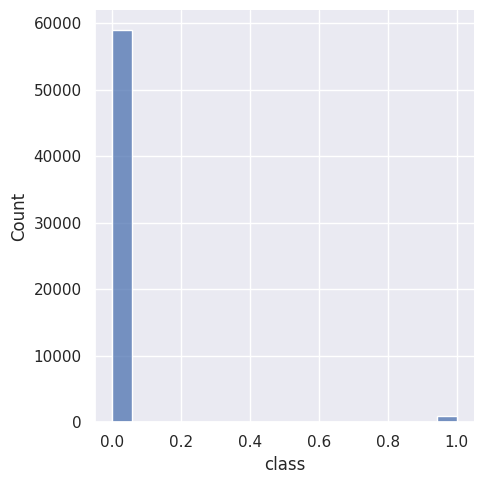

In [32]:
sns.displot(df4['class'],kde=False);

In [33]:
df4['class'].value_counts()

0    59000
1     1000
Name: class, dtype: int64

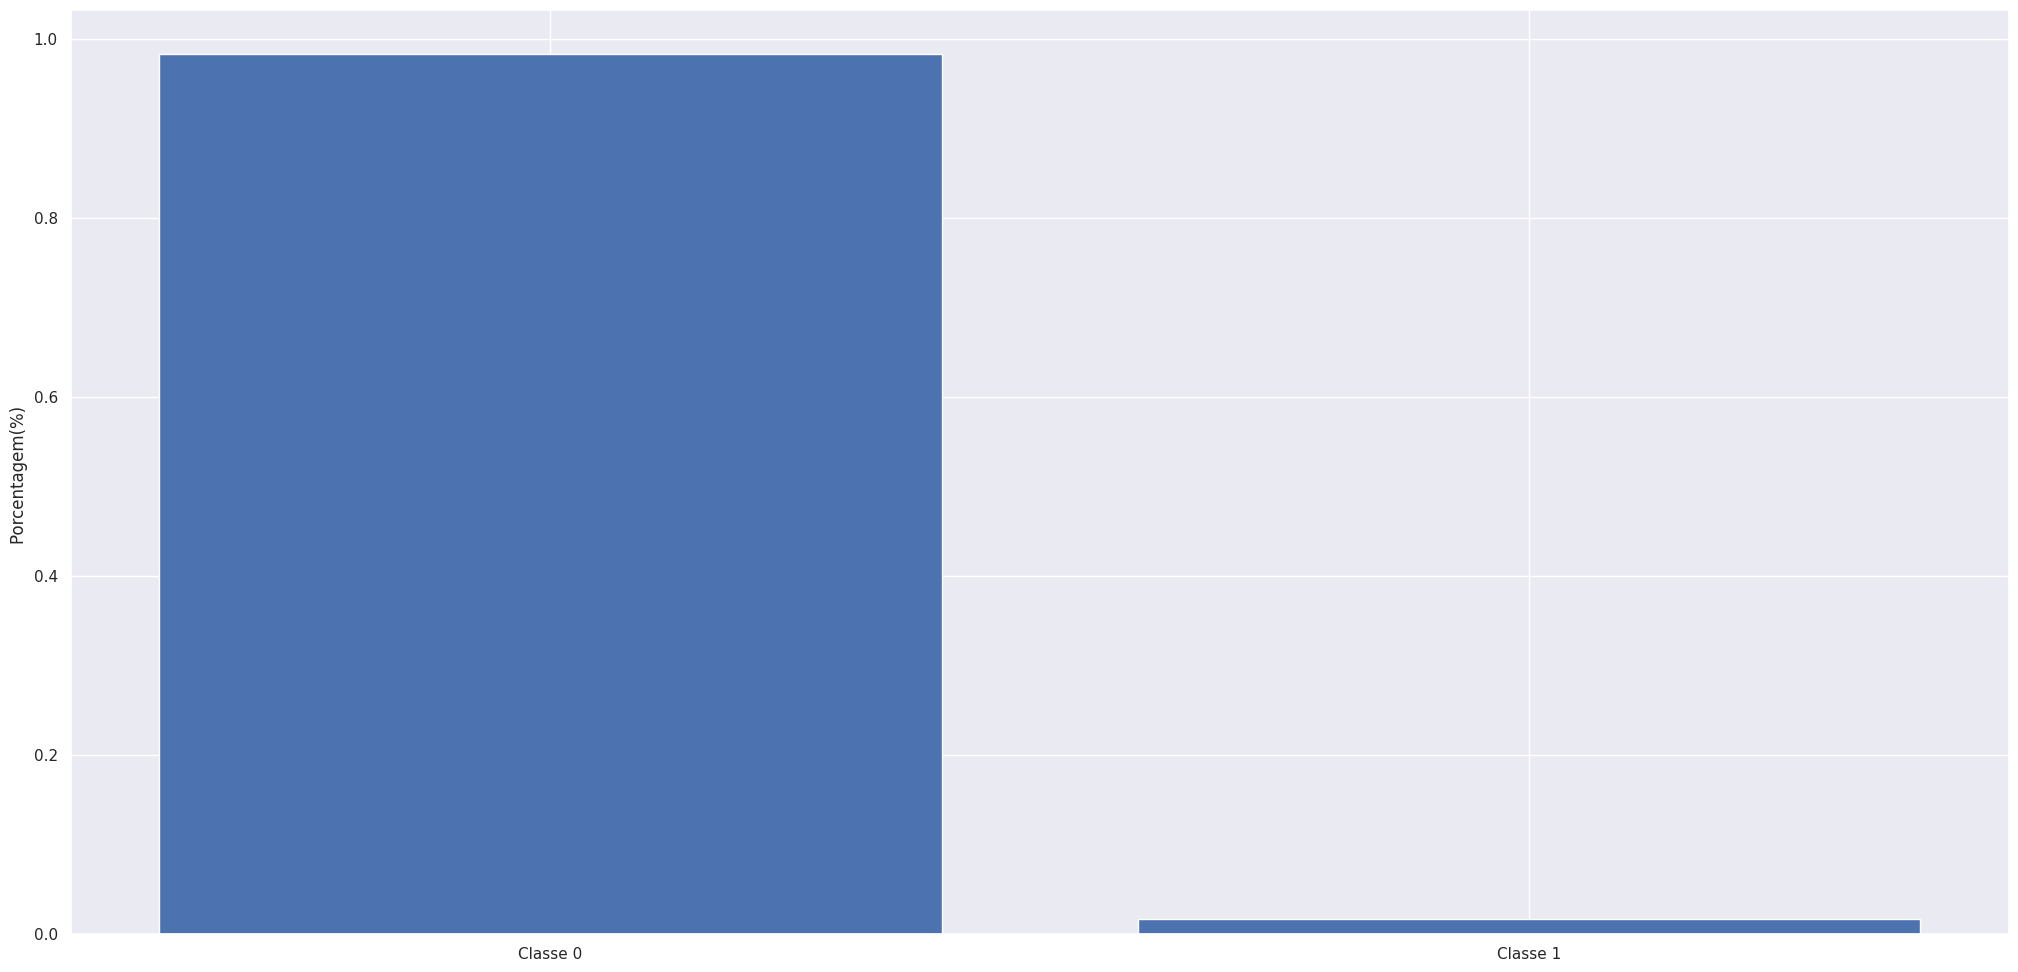

In [34]:
distri = df4['class'].value_counts(normalize=True) 
plt.bar(x=distri.index,height=distri)
plt.xticks([0,1],['Classe 0','Classe 1'])
plt.ylabel('Porcentagem(%) ');


In [35]:
distri

0   0.9833
1   0.0167
Name: class, dtype: float64

- 59000 caminhões com outros tipos de manutenção. (98%)
- 1000 caminhões com manutenção de sistema de ar. (2%)

## 4.2 Numerical Variables

In [36]:
## CORRELATION 170

# 5.0 Data Preparation

In [37]:
df5 = df4.copy()

In [38]:
X = df4.drop('class',axis=1)
y = df4['class'].copy()

In [39]:
x_train, x_validation, y_train, y_validation = ms.train_test_split(X,y,test_size=0.20,random_state=42)

In [40]:
x_train.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
48572,18.0000,0.0000,22.0000,20.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,1916.0000,2956.0000,0.0000,0.0000,0.0000,606.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6408.0000,4912.0000,31398.0000,492.0000,0.0000,0.0000,0.0000,0.0000,10.0000,22.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,960.0000,3922.0000,0.0000,98.0000,58.0000,84.0000,1010.0000,128.0000,3504.0000,0.0000,0.0000,0.0000,0.0000,3344.0000,416.0000,156.0000,94.0000,180.0000,108.0000,444.0000,62.0000,10.0000,68.0000,37822.0000,0.0000,6.0000,0.0000,0.0000,606.0000,126.0000,29982.0000,1396.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,31280.0000,17.9600,37822.0000,37822.0000,39494.0000,23.0000,10.0000,3732.0000,37700.0000,4934.0000,1209600.0000,322.0000,2.0000,0.0000,0.0000,2637.1200,286.0800,995.5200,2.0000,22.0000,0.0000,0.0000,0.0000,1272.0000,2714.0000,890.0000,6.0000,0.0000,0.0000,0.0000,0.0000,22.0000,37822.0000,0.0000,1030.0000,12.0000,18.0000,16.0000,346.0000,916.0000,2078.0000,448.0000,18.0000,0.0000,6.0000,28.0000,2530.0000,104.0000,0.0000,0.0000,0.0000,0.0000,2854.0000,32.0000,96.0000,0.0000,0.0000,280.0000,1666.0000,0.0000,0.0000,0.0000,0.0000,176.0000,0.0000,0.0000,0.0000,0.0000,62.0000,18.0000,10260.0000,1036.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.7600,44.0000,2434.0000,1962.0000,126.0000,64.0000,104.0000,154.0000,38.0000,0.0000,0.0000,0.0000,0.0000,0.0000
38696,30.0000,0.0000,42.0000,42.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,50.0000,4250.0000,3442.0000,0.0000,0.0000,0.0000,3058.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7478.0000,5016.0000,12224.0000,1182.0000,0.0000,0.0000,0.0000,0.0000,108.0000,30.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7742.0000,0.0000,0.0000,0.0000,52.0000,6.0000,10.0000,20.0000,180.0000,7432.0000,42.0000,0.0000,0.0000,0.0000,6030.0000,1288.0000,274.0000,66.0000,32.0000,18.0000,16.0000,18.0000,0.0000,0.0000,19714.0000,4.0000,20.0000,6.0000,0.0000,3058.0000,200.0000,9554.0000,2664.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12100.0000,29.5100,19714.0000,19714.0000,25582.0000,17.0000,0.0000,1882.0000,19620.0000,7742.0000,1209600.0000,618.0000,0.0000,2.0000,0.0000,4595.5200,0.0000,3117.1200,0.0000,0.0000,0.0000,0.0000,0.0000,3722.0000,3834.0000,186.0000,0.0000,0.0000,0.0000,0.0000,6.0000,36.0000,19714.0000,0.0000,68.0000,10.0000,12.0000,268.0000,506.0000,1156.0000,4324.0000,1350.0000,48.0000,0.0000,72.0000,78.0000,5032.0000,66.0000,0.0000,28.0000,0.0000,0.0000,5124.0000,56.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,120.0000,0.0000,0.0000,0.0000,0.0000,254.0000,50.0000,520.0000,58.0000,20522.0000,32.0000,0.0000,0.0000,0.0000,43.3200,28.0000,3470.0000,3348.0000,734.0000,82.0000,102.0000,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
13611,14.0000,0.0000,8.0000,0.0000,0.0000,0.0000,

## 5.1 Data Resampling -> UNDERSAMPLING

In [41]:
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule

In [42]:
# distri = df4['class'].value_counts(normalize=True) 

In [43]:
# y_train.value_counts()

In [44]:
# y_train.value_counts(normalize=True)

### 5.1.2 OneSidedSelection ( Tomek Links + Condensed Nearest Neighbours)

In [45]:
# # Define undersampling method
# undersample = OneSidedSelection(n_neighbors=1,n_seeds_S=200,random_state=42)

# x_train ,y_train = undersample.fit_resample(x_train,y_train)

In [46]:
# y_train.value_counts()

In [47]:
# y_train.value_counts(normalize=True)

### 5.1.3 NeighbourhoodCleaning Rule ( Condensed Nearest Neighbours + Edited Nearest Neighbors)

In [48]:
# x_train.head()

In [49]:
undersample = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)

x_train ,y_train = undersample.fit_resample(x_train,y_train)


In [50]:
x_train.shape

(47065, 170)

In [51]:
y_train.value_counts()

0    46277
1      788
Name: class, dtype: int64

In [52]:
y_train.value_counts(normalize=True)

0   0.9833
1   0.0167
Name: class, dtype: float64

## 5.2 Rescaling Features

In [53]:
from sklearn import preprocessing as pp

In [54]:
x_train.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,18.0000,0.0000,22.0000,20.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,10.0000,1916.0000,2956.0000,0.0000,0.0000,0.0000,606.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6408.0000,4912.0000,31398.0000,492.0000,0.0000,0.0000,0.0000,0.0000,10.0000,22.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,960.0000,3922.0000,0.0000,98.0000,58.0000,84.0000,1010.0000,128.0000,3504.0000,0.0000,0.0000,0.0000,0.0000,3344.0000,416.0000,156.0000,94.0000,180.0000,108.0000,444.0000,62.0000,10.0000,68.0000,37822.0000,0.0000,6.0000,0.0000,0.0000,606.0000,126.0000,29982.0000,1396.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,31280.0000,17.9600,37822.0000,37822.0000,39494.0000,23.0000,10.0000,3732.0000,37700.0000,4934.0000,1209600.0000,322.0000,2.0000,0.0000,0.0000,2637.1200,286.0800,995.5200,2.0000,22.0000,0.0000,0.0000,0.0000,1272.0000,2714.0000,890.0000,6.0000,0.0000,0.0000,0.0000,0.0000,22.0000,37822.0000,0.0000,1030.0000,12.0000,18.0000,16.0000,346.0000,916.0000,2078.0000,448.0000,18.0000,0.0000,6.0000,28.0000,2530.0000,104.0000,0.0000,0.0000,0.0000,0.0000,2854.0000,32.0000,96.0000,0.0000,0.0000,280.0000,1666.0000,0.0000,0.0000,0.0000,0.0000,176.0000,0.0000,0.0000,0.0000,0.0000,62.0000,18.0000,10260.0000,1036.0000,0.0000,20.0000,0.0000,0.0000,0.0000,0.7600,44.0000,2434.0000,1962.0000,126.0000,64.0000,104.0000,154.0000,38.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,30.0000,0.0000,42.0000,42.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,50.0000,4250.0000,3442.0000,0.0000,0.0000,0.0000,3058.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7478.0000,5016.0000,12224.0000,1182.0000,0.0000,0.0000,0.0000,0.0000,108.0000,30.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7742.0000,0.0000,0.0000,0.0000,52.0000,6.0000,10.0000,20.0000,180.0000,7432.0000,42.0000,0.0000,0.0000,0.0000,6030.0000,1288.0000,274.0000,66.0000,32.0000,18.0000,16.0000,18.0000,0.0000,0.0000,19714.0000,4.0000,20.0000,6.0000,0.0000,3058.0000,200.0000,9554.0000,2664.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,12100.0000,29.5100,19714.0000,19714.0000,25582.0000,17.0000,0.0000,1882.0000,19620.0000,7742.0000,1209600.0000,618.0000,0.0000,2.0000,0.0000,4595.5200,0.0000,3117.1200,0.0000,0.0000,0.0000,0.0000,0.0000,3722.0000,3834.0000,186.0000,0.0000,0.0000,0.0000,0.0000,6.0000,36.0000,19714.0000,0.0000,68.0000,10.0000,12.0000,268.0000,506.0000,1156.0000,4324.0000,1350.0000,48.0000,0.0000,72.0000,78.0000,5032.0000,66.0000,0.0000,28.0000,0.0000,0.0000,5124.0000,56.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,120.0000,0.0000,0.0000,0.0000,0.0000,254.0000,50.0000,520.0000,58.0000,20522.0000,32.0000,0.0000,0.0000,0.0000,43.3200,28.0000,3470.0000,3348.0000,734.0000,82.0000,102.0000,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,14.0000,0.0000,8.0000,0.0000,0.0000,0.0000,0.0000,0.000

In [55]:
# # x_train = pd.DataFrame(sc.fit_transform(x_train.values), columns=x_train.columns, index=x_train.index)
# # x_validation = pd.DataFrame(sc.fit_transform(x_validation.values), columns=x_validation.columns, index=x_validation.index)

sc = pp.StandardScaler()

x_train_scaler = sc.fit_transform(x_train)
x_val_scaler = sc.transform(x_validation)

# WITHOUT COLUMS NAMES
# x_train = pd.DataFrame(x_train_scaler)
# x_validation = pd.DataFrame(x_val_scaler)

# # #WITH COLUMNS NAMES
x_train = pd.DataFrame(x_train_scaler,columns=x_train.columns)
x_validation = pd.DataFrame(x_val_scaler,columns=x_validation.columns)




In [56]:
x_train.shape

(47065, 170)

In [57]:
x_validation.shape

(12000, 170)

## 5.3 PCA

In [58]:
# from sklearn import decomposition as d

In [59]:
# # PCA Definition 
# pca = d.PCA().fit(x_train_scaler)

In [60]:
# # Defintion of the eingenvectors(autovetors) + eigenvalues (autovalores) --> Variabilidade das variáveis
# pca.explained_variance_ratio_

In [61]:
# np.cumsum(pca.explained_variance_ratio_)

In [62]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.axvline(81,color='red',linestyle='--')
# plt.axhline(0.95,color='black', linestyle='--')

In [63]:
# # Definição dos autovetores 
# k = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)
# k


In [64]:
# # Criação do Nova Espaço com autovetores definidos
# pca = d.PCA(k).fit(x_train_scaler)

# # Aplicando PCA nos dados de treino e validação
# x_train = pca.transform(x_train_scaler)
# x_validation = pca.transform(x_val_scaler)



In [65]:
# # Transformacao dos array de treino e validacao para DF, pois nosso algoritmos são aplicados diretamente neles
# x_train = pd.DataFrame(x_train)
# x_validation = pd.DataFrame(x_validation)

# 6.0 Feature Selection 

In [66]:
df5.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698.0000,0.0000,2130706438.0000,280.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,37250.0000,1432864.0000,3664156.0000,1007684.0000,25896.0000,0.0000,2551696.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4933296.0000,3655166.0000,1766008.0000,1132040.0000,0.0000,0.0000,0.0000,0.0000,1012.0000,268.0000,0.0000,0.0000,0.0000,0.0000,0.0000,469014.0000,4239660.0000,703300.0000,755876.0000,0.0000,5374.0000,2108.0000,4114.0000,12348.0000,615248.0000,5526276.0000,2378.0000,4.0000,0.0000,0.0000,2328746.0000,1022304.0000,415432.0000,287230.0000,310246.0000,681504.0000,1118814.0000,3574.0000,0.0000,0.0000,6700214.0000,0.0000,10.0000,108.0000,50.0000,2551696.0000,97518.0000,947550.0000,799478.0000,330760.0000,353400.0000,299160.0000,305200.0000,283680.0000,0.0000,0.0000,0.0000,178540.0000,76698.0800,6700214.0000,6700214.0000,6599892.0000,43566.0000,68656.0000,54064.0000,638360.0000,6167850.0000,1209600.0000,246244.0000,2.0000,96.0000,0.0000,5245752.0000,0.0000,916567.6800,6.0000,1924.0000,0.0000,0.0000,0.0000,118196.0000,1309472.0000,3247182.0000,1381362.0000,98822.0000,11208.0000,1608.0000,220.0000,240.0000,6700214.0000,0.0000,10476.0000,1226.0000,267998.0000,521832.0000,428776.0000,4015854.0000,895240.0000,26330.0000,118.0000,0.0000,532.0000,734.0000,4122704.0000,51288.0000,0.0000,532572.0000,0.0000,18.0000,5330690.0000,4732.0000,1126.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,62282.0000,85908.0000,32790.0000,0.0000,0.0000,202710.0000,37928.0000,14745580.0000,1876644.0000,0.0000,0.0000,0.0000,0.0000,2801180.0000,2445.8000,2712.0000,965866.0000,1706908.0000,1240520.0000,493384.0000,721044.0000,469792.0000,339156.0000,157956.0000,73224.0000,0.0000,0.0000,0.0000
1,0,33058.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,18254.0000,653294.0000,1720800.0000,516724.0000,31642.0000,0.0000,1393352.0000,0.0000,68.0000,0.0000,0.0000,0.0000,2560898.0000,2127150.0000,1084598.0000,338544.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,71510.0000,772720.0000,1996924.0000,99560.0000,0.0000,7336.0000,7808.0000,13776.0000,13086.0000,1010074.0000,1873902.0000,14726.0000,6.0000,0.0000,0.0000,1378576.0000,447166.0000,199512.0000,154298.0000,137280.0000,138668.0000,165908.0000,229652.0000,87082.0000,4708.0000,3646660.0000,86.0000,454.0000,364.0000,350.0000,1393352.0000,49028.0000,688314.0000,392208.0000,341420.0000,359780.0000,366560.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6700.0000,33057.5100,3646660.0000,3646660.0000,3582034.0000,17733.0000,260120.0000,115626.0000,6900.0000,2942850.0000,1209600.0000,0.0000,0.0000,0.0000,0.0000,2291079.3600,0.0000,643536.9600,0.0000,0.0000,0.0000,0.0000,38.0000,98644.0000,1179502.0000,1286736.0000,336388.0000,36294.0000,5192.0000,56.0000,0.0000,0.0000,3646660.0000,0.0000,6160.0000,

In [67]:
df6 = df5.drop(columns=['class'],axis=1)
df6_class = df5['class'].copy()

In [68]:
x_train_n = x_train.copy()
y_train_n = y_train.values

## 6.1 Feature Importance with ET, RF, XGBoost


In [69]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestClassifier

### 6.1.1 ExtraTrees

In [70]:
# extratree = ExtraTreesClassifier(n_estimators=250,random_state=42,n_jobs=-1)
# extra_tree_features = feature_importance(extratree,x_train_n,y_train_n)

# extra_tree_features = extra_tree_features[extra_tree_features['importance'] >= 0.005]
# cols_selected_et = extra_tree_features['feature'].values

In [71]:
# cols_selected_et

In [72]:
# cols_selected_et.size

### 6.1.2 RandomForest Feature Importance

In [73]:
# from sklearn.ensemble import RandomForestClassifier

In [74]:
# rf = RandomForestClassifier(n_jobs=-1,random_state=42)
# rf_features = feature_importance(rf,x_train_n,y_train_n)

# rf_features = rf_features[rf_features['importance'] >= 0.005]
# cols_selected_rf = rf_features['feature'].values

In [75]:
# cols_selected_rf

In [76]:
# cols_selected_rf.size

### 6.1.3 XGBoost Feature Selection

In [77]:
import matplotlib.pyplot as plt

In [78]:
x_train_n.shape

(47065, 170)

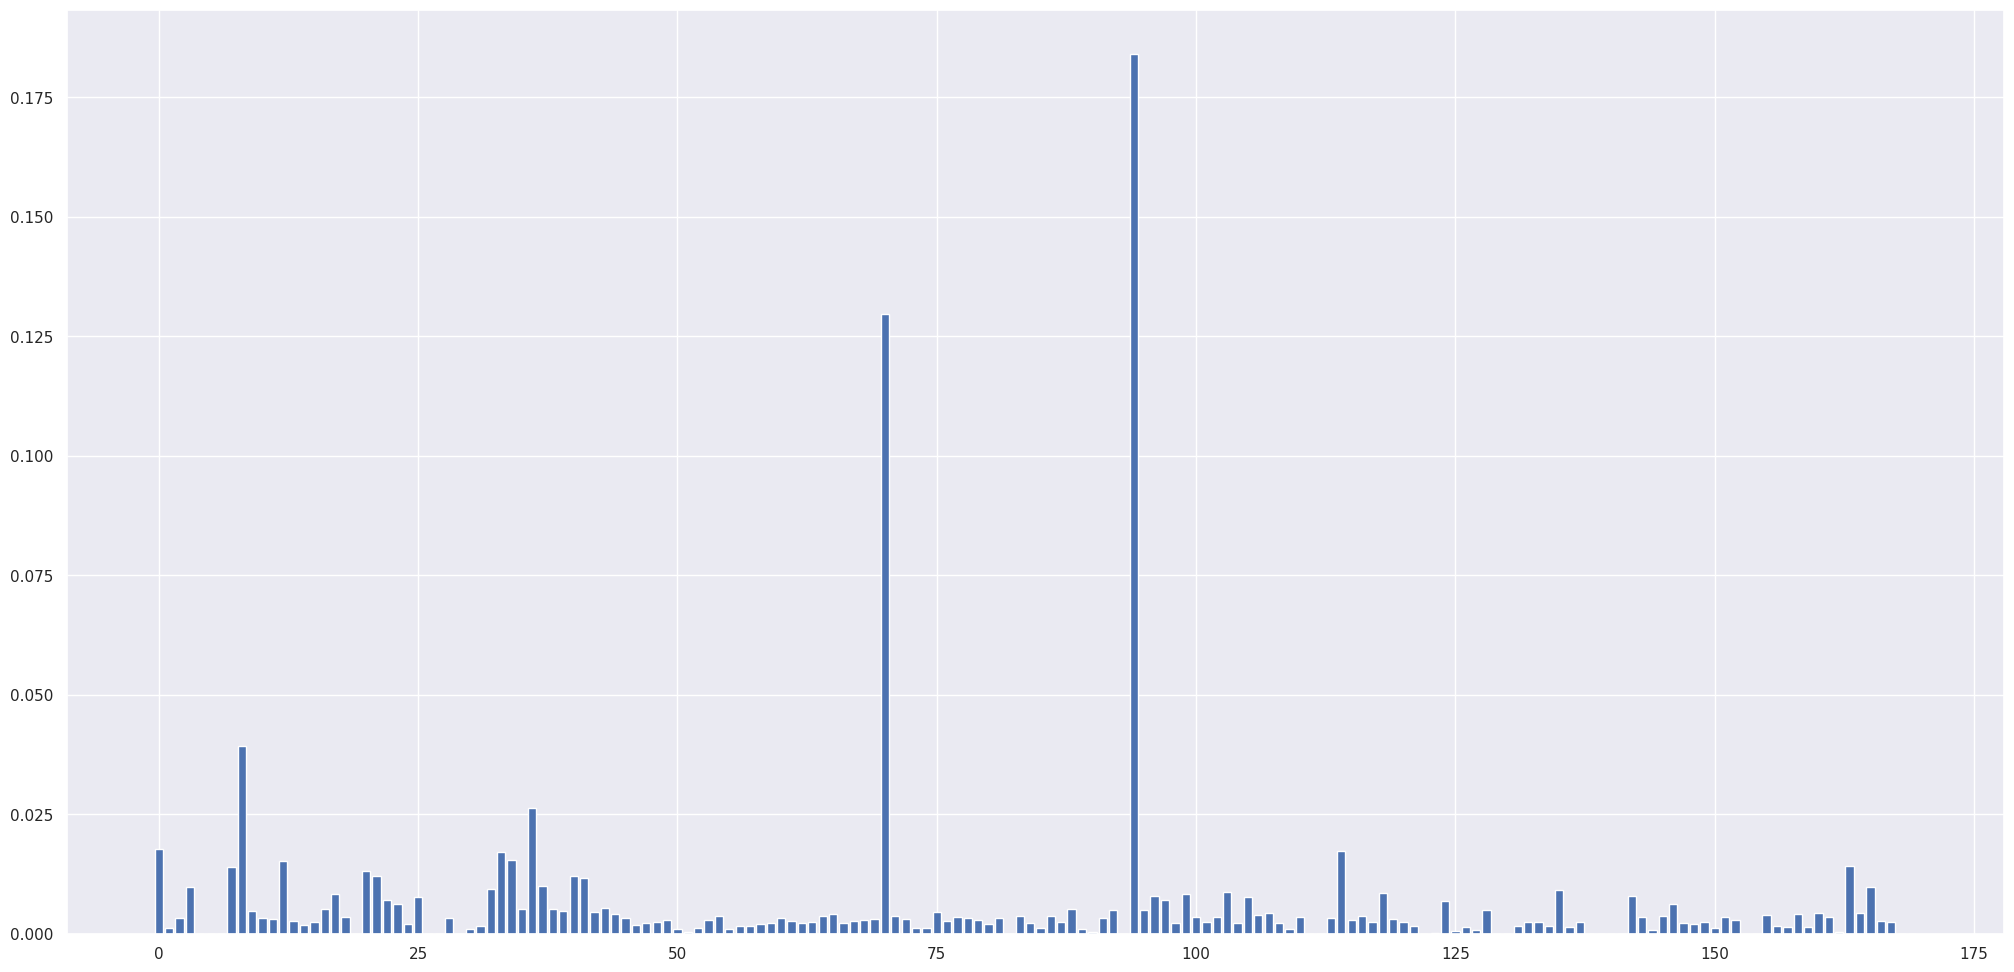

In [79]:
xgb = XGBClassifier(n_jobs=-1,random_state=42)
xgb.fit(x_train_n,y_train_n)

# x = ['importance']
xgb_features = pd.DataFrame(xgb.feature_importances_,)
xgb_features.columns = ['importance']


plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()


In [80]:
xgb_features_final = xgb_features[xgb_features['importance'] >= 0.0050].sort_values('importance',ascending=False)
cols_selected_xgb = xgb_features_final.index

In [81]:
cols_selected_xgb.size

39

In [82]:
cols_selected_xgb

Int64Index([ 94,  70,   8,  36,   0, 114,  33,  34,  12, 163,   7,  20,  21,
             40,  41,  37, 165,   3,  32, 135, 103, 118,  99,  17, 142,  96,
            105,  25,  22,  97, 124, 146,  23,  43,  38,  88,  16,  35,  95],
           dtype='int64')

In [83]:
cols_selected = df6.iloc[:,[ 94,  70,   8,  36,   0, 114,  33,  34,  12, 163,   7,  20,  21,
             40,  41,  37, 165,   3,  32, 135, 103, 118,  99,  17, 142,  96,
            105,  25,  22,  97, 124, 146,  23,  43,  38,  88,  16,  35,  95]].columns

In [84]:
cols_selected

Index(['ci_000', 'bj_000', 'ag_002', 'ay_004', 'aa_000', 'cs_001', 'ay_001',
       'ay_002', 'ag_006', 'ee_005', 'ag_001', 'al_000', 'am_0', 'ay_008',
       'ay_009', 'ay_005', 'ee_007', 'ad_000', 'ay_000', 'dg_000', 'cn_004',
       'cs_005', 'cn_000', 'ai_000', 'dn_000', 'ck_000', 'cn_006', 'aq_000',
       'an_000', 'cl_000', 'cu_000', 'dr_000', 'ao_000', 'az_001', 'ay_006',
       'cc_000', 'ah_000', 'ay_003', 'cj_000'],
      dtype='object')

## 6.5 ANNOVA

In [85]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif

In [86]:
# fs = SelectKBest(score_func=f_classif,k=60)
# fs.fit(x_train_n,y_train_n)

# # Get columns to keep and create new dataframe with those only
# cols_selected_annova = fs.get_support(indices=True)


# x_train = x_train[cols_selected]
# x_validation = x_validation[cols_selected]

## 6.6 Features Final Selection

In [87]:
# cols_selected_annova
# cols_selected_rf 
# cols_selected_et 
# cols_selected_xgb

x_train = x_train[cols_selected]
x_validation = x_validation[cols_selected]

In [88]:
x_train.head()

,ci_000,bj_000,ag_002,ay_004,aa_000,cs_001,ay_001,ay_002,ag_006,ee_005,ag_001,al_000,am_0,ay_008,ay_009,ay_005,ee_007,ad_000,ay_000,dg_000,cn_004,cs_005,cn_000,ai_000,dn_000,ck_000,cn_006,aq_000,an_000,cl_000,cu_000,dr_000,ao_000,az_001,ay_006,cc_000,ah_000,ay_003,cj_000
0,-0.4081,-0.2657,-0.0544,-0.0276,-0.4018,-0.2353,-0.0219,-0.0246,-0.4288,-0.3397,-0.0296,-0.1004,-0.0992,-0.2505,-0.0102,-0.0759,-0.1957,-0.0046,-0.0244,-0.0248,-0.3779,-0.4068,-0.0354,-0.0499,-0.3459,-0.3145,-0.3192,-0.3460,-0.4399,-0.0629,-0.1494,-0.1352,-0.4348,-0.1149,-0.3341,-0.3743,-0.4310,-0.0331,-0.0809
1,-0.4078,-0.2649,-0.0544,-0.0276,-0.4017,-0.2360,-0.0219,-0.0246,-0.4286,-0.3398,-0.0296,-0.1004,-0.0992,-0.2516,-0.0102,-0.0759,-0.1957,-0.0046,-0.0244,-0.0248,-0.3775,-0.4067,-0.0354,-0.0499,-0.3466,-0.3134,-0.3192,-0.3454,-0.4398,-0.0635,-0.1406,-0.1352,-0.4348,-0.1165,-0.3315,-0.3740,-0.4303,-0.0331,-0.0812
2,-0.4082,-0.2648,-0.0544,-0.0276,-0.4019,-0.2346,-0.0219,-0.0246,-0.4289,-0.3398,-0.0296,-0.1004,-0.0992,-0.2512,-0.0102,-0.0759,-0.1956,-0.0046,-0.0244,-0.0248,-0.3779,-0.4063,-0.0354,-0.0499,-0.3454,-0.3134,-0.3192,-0.3459,-0.4403,-0.0635,-0.1543,-0.1349,-0.4354,-0.1160,-0.3341,-0.3742,-0.4306,-0.0331,-0.0812
3,-0.0971,-0.1066,-0.0544,-0.0276,-0.0746,-0.0604,-0.0219,-0.0246,0.0276,0.0812,-0.0296,-0.1004,-0.0992,-0.2516,-0.0102,-0.0759,-0.0756,-0.0046,-0.0244,-0.0248,-0.1667,-0.0733,-0.0354,-0.0499,-0.0540,-0.1557,0.1633,-0.0618,-0.1105,-0.0629,-0.0172,-0.1352,-0.1228,-0.0831,0.2197,-0.0667,-0.1097,-0.0331,-0.0812
4,0.0505,-0.1034,-0.0544,-0.0276,0.0671,0.1967,-0.0219,-0.0246,0.3411,0.1250,-0.0296,-0.1004,-0.0992,-0.2513,-0.0102,-0.0759,0.1436,-0.0046,-0.0244,-0.0248,0.2254,0.1616,-0.0354,-0.0499,0.0463,-0.1413,-0.1118,-0.0406,0.0470,-0.0635,-0.1543,-0.1352,0.0476,-0.0989,0.8648,0.0661,0.0992,-0.0331,-0.0812


# 6.8 Analyze Correlation Between Variables

In [89]:
df_correlation = df6[cols_selected]

In [90]:
df_correlation = pd.concat([df_correlation,df6_class],axis=1)

In [91]:
df_correlation.head()

,ci_000,bj_000,ag_002,ay_004,aa_000,cs_001,ay_001,ay_002,ag_006,ee_005,ag_001,al_000,am_0,ay_008,ay_009,ay_005,ee_007,ad_000,ay_000,dg_000,cn_004,cs_005,cn_000,ai_000,dn_000,ck_000,cn_006,aq_000,an_000,cl_000,cu_000,dr_000,ao_000,az_001,ay_006,cc_000,ah_000,ay_003,cj_000,class
0,5245752.0000,799478.0000,0.0000,0.0000,76698.0000,1226.0000,0.0000,0.0000,3664156.0000,469792.0000,0.0000,0.0000,0.0000,755876.0000,0.0000,469014.0000,157956.0000,280.0000,0.0000,0.0000,1309472.0000,4015854.0000,0.0000,0.0000,62282.0000,916567.6800,1381362.0000,1132040.0000,4933296.0000,6.0000,734.0000,0.0000,3655166.0000,2108.0000,4239660.0000,6167850.0000,2551696.0000,0.0000,0.0000,0
1,2291079.3600,392208.0000,0.0000,0.0000,33058.0000,796.0000,0.0000,0.0000,1720800.0000,245416.0000,0.0000,0.0000,0.0000,99560.0000,0.0000,71510.0000,81140.0000,0.0000,0.0000,0.0000,1179502.0000,1837600.0000,0.0000,0.0000,33736.0000,643536.9600,336388.0000,338544.0000,2560898.0000,0.0000,0.0000,0.0000,2127150.0000,7808.0000,772720.0000,2942850.0000,1393352.0000,0.0000,0.0000,0
2,2322692.1600,139730.0000,0.0000,0.0000,41040.0000,500.0000,0.0000,0.0000,1883374.0000,409564.0000,0.0000,0.0000,0.0000,1450312.0000,0.0000,0.0000,158022.0000,100.0000,0.0000,0.0000,1215280.0000,1744838.0000,0.0000,0.0000,13876.0000,236099.5200,196502.0000,153698.0000,2371990.0000,0.0000,292.0000,0.0000,2173634.0000,1156.0000,870456.0000,2560566.0000,1234132.0000,0.0000,0.0000,0
3,2135.0400,3090.0000,0.0000,0.0000,12.0000,6.0000,0.0000,0.0000,1872.0000,44.0000,0.0000,642.0000,3894.0000,5596.0000,0.0000,0.0000,0.0000,66.0000,0.0000,0.0000,2170.0000,4836.0000,0.0000,0.0000,232.0000,4525.4400,152.0000,1014.0000,10184.0000,2.0000,8.0000,370.0000,7554.0000,6.0000,0.0000,7710.0000,2668.0000,0.0000,0.0000,0
4,3565684.8000,399410.0000,0.0000,42124.0000,60874.0000,520.0000,0.0000,0.0000,1800340.0000,347188.0000,0.0000,0.0000,0.0000,584074.0000,0.0000,372236.0000,311560.0000,458.0000,0.0000,0.0000,2497104.0000,2288268.0000,0.0000,0.0000,44946.0000,379111.6800,64230.0000,551022.0000,3230626.0000,0.0000,1664.0000,0.0000,2618878.0000,362.0000,2128914.0000,3946944.0000,1974038.0000,0.0000,0.0000,0


module://matplotlib_inline.backend_inline


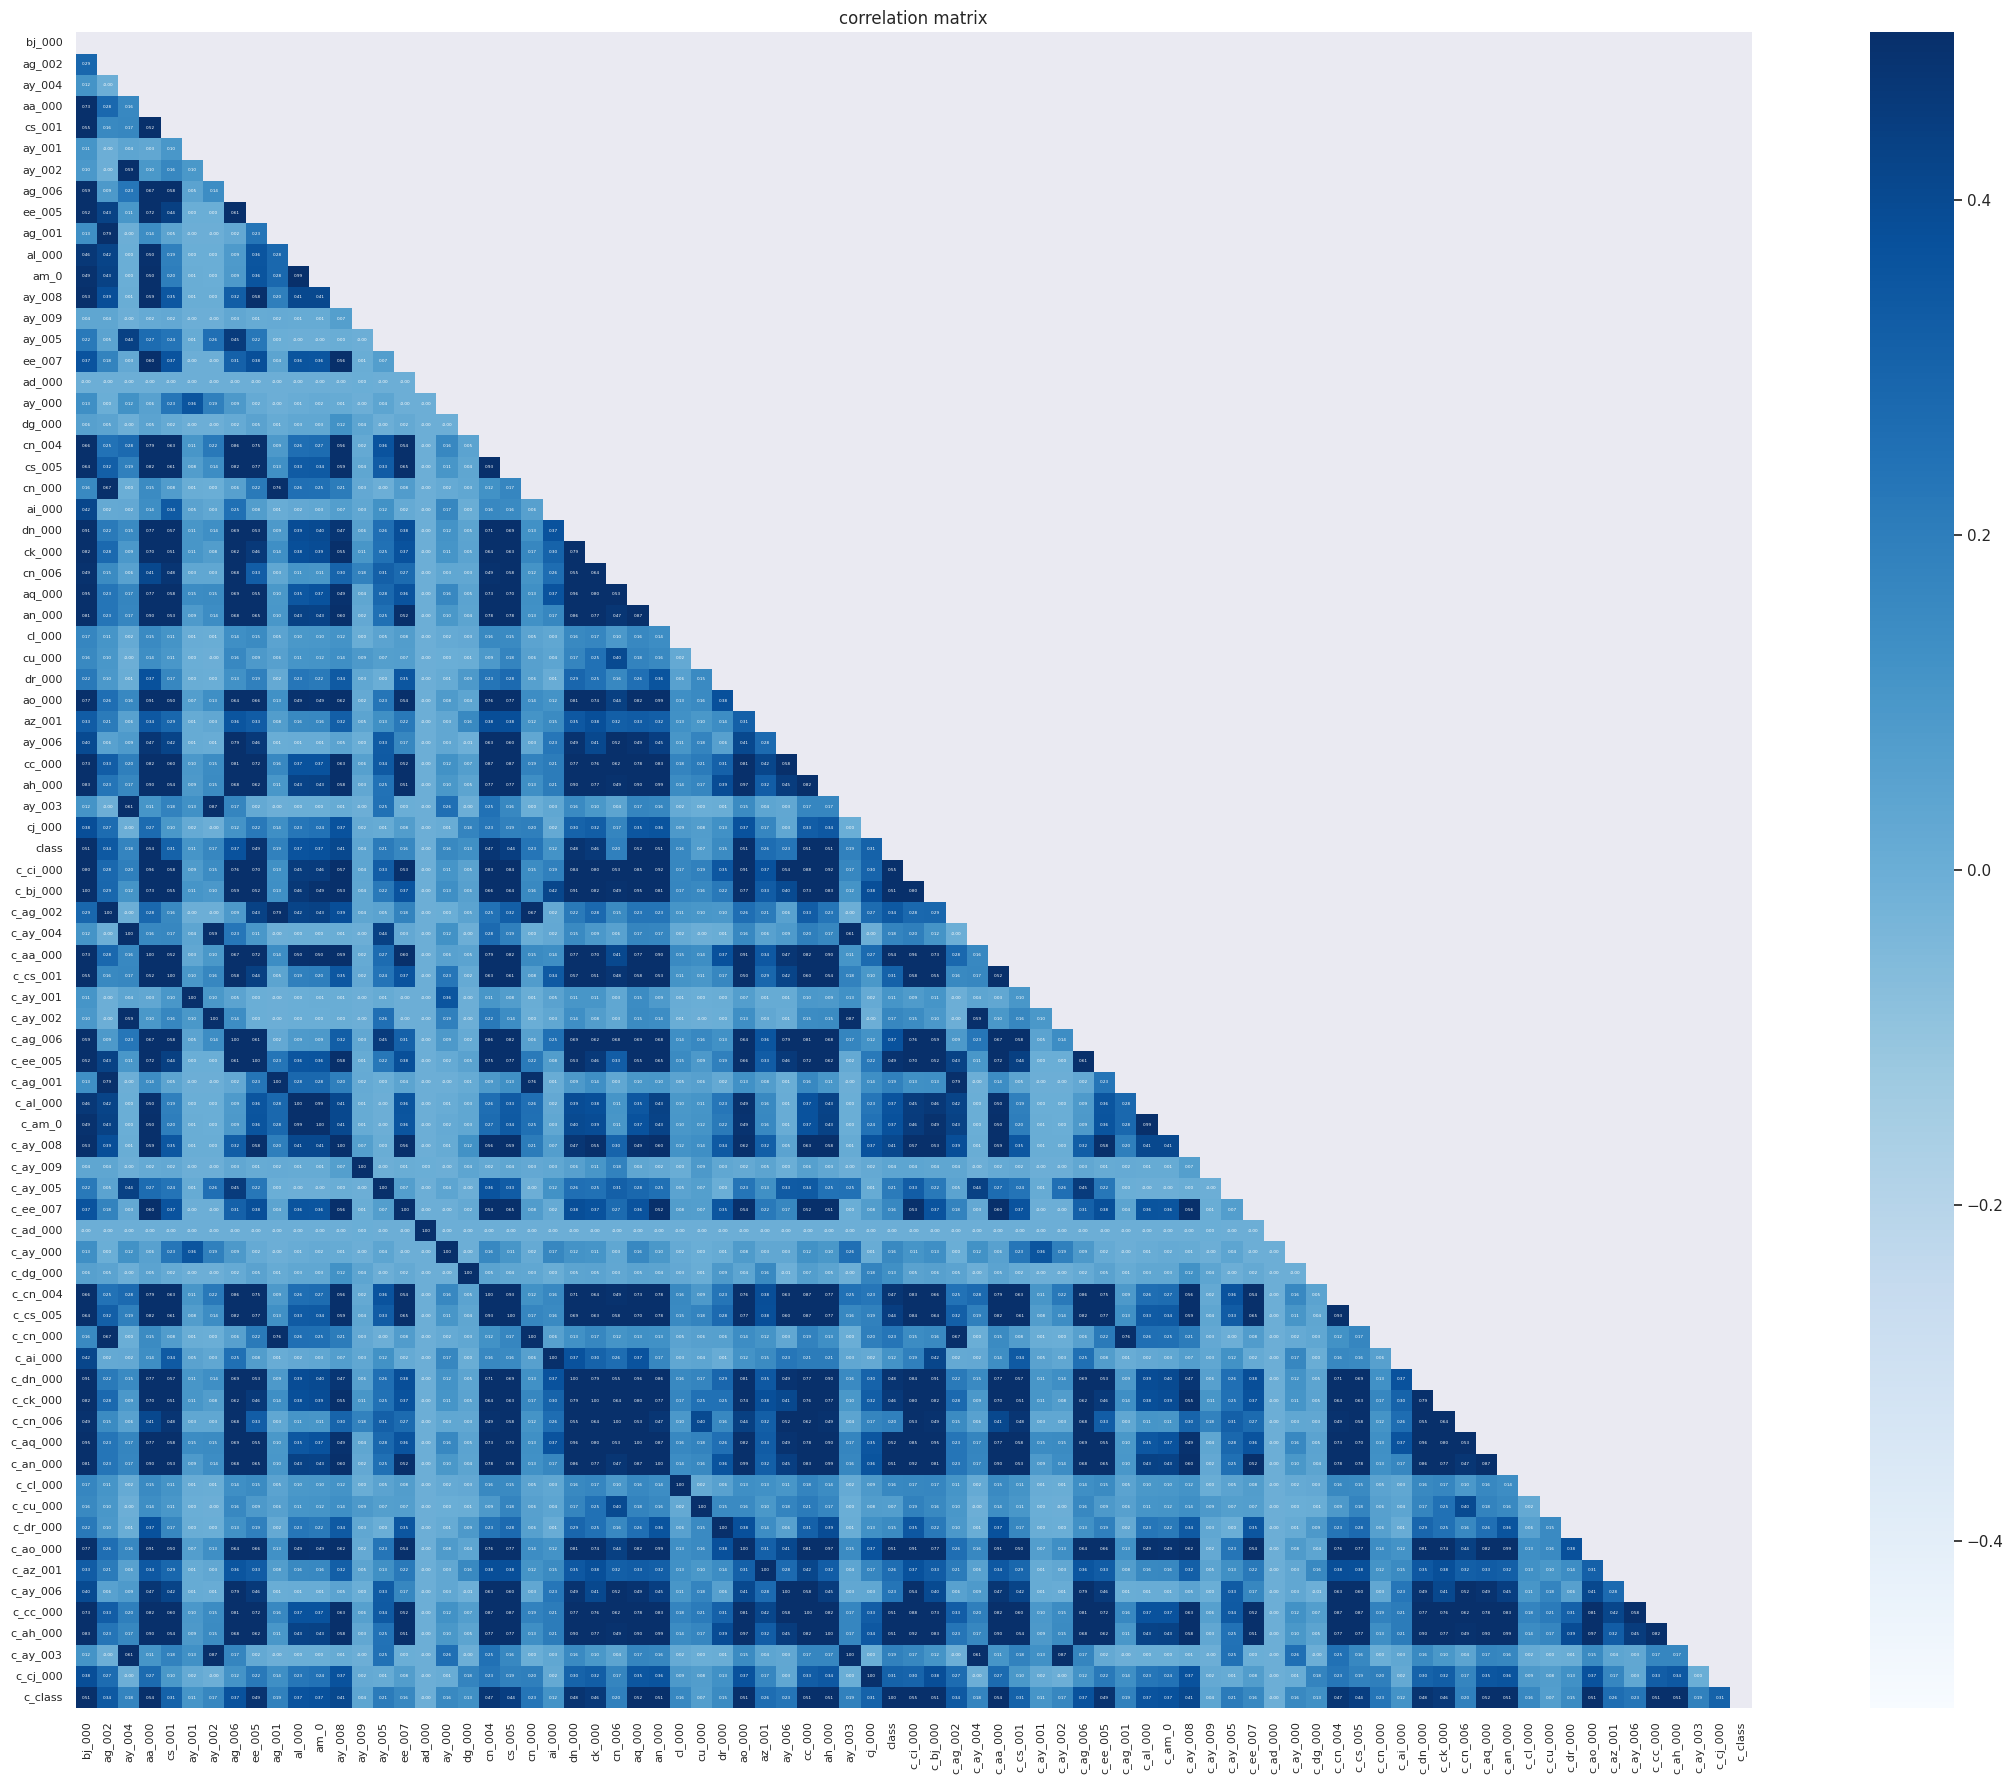

In [92]:
print(plt.get_backend())

# close any existing plots
plt.close("all")

# copy columns to double size of dataframe
df_aux = df_correlation.copy()
df_aux.columns = "c_" + df_aux.columns
df_aux2 = pd.concat([df_correlation, df_aux], axis=1)

# get the correlation coefficient between the different columns
corr = df_aux2.iloc[:, 1:].corr()
arr_corr = corr.to_numpy()
# mask out the top triangle
arr_corr[np.triu_indices_from(arr_corr)] = np.nan

fig, ax = plt.subplots(figsize=(24, 18))

hm = sns.heatmap(arr_corr, cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'size': 3}, annot=True, 
                 square=True, cmap=plt.cm.Blues)

ticks = np.arange(corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corr.index, rotation=360, fontsize=8)

ax.set_title('correlation matrix')
plt.tight_layout()
plt.savefig("corr_matrix_big_size_41features.png", dpi=300)

# 7.0 Machine Learning Model

## 7.1 KNN Base Model 

,Model_Name,Recall,F1_Score,PRC AUC,AUC SCORE
0,KNeighborsClassifier,0.7123,0.6959,0.6696,0.9486


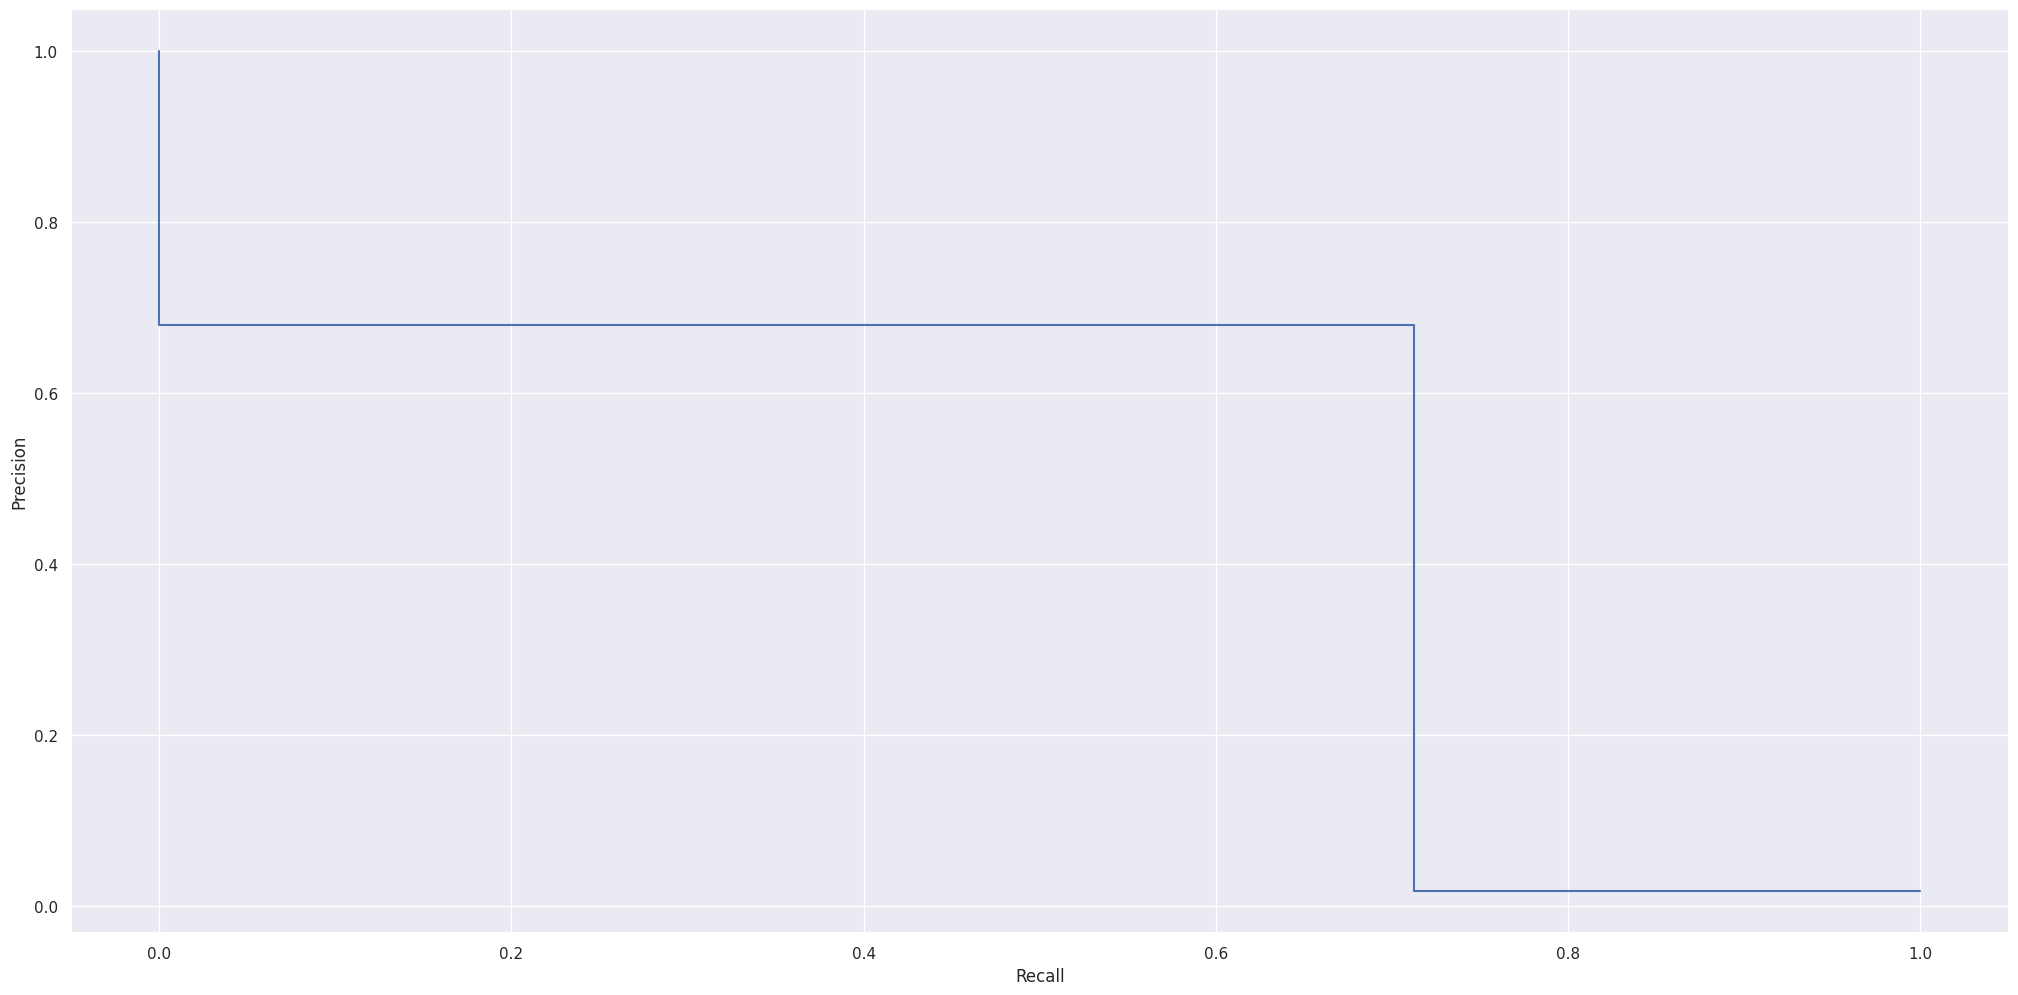

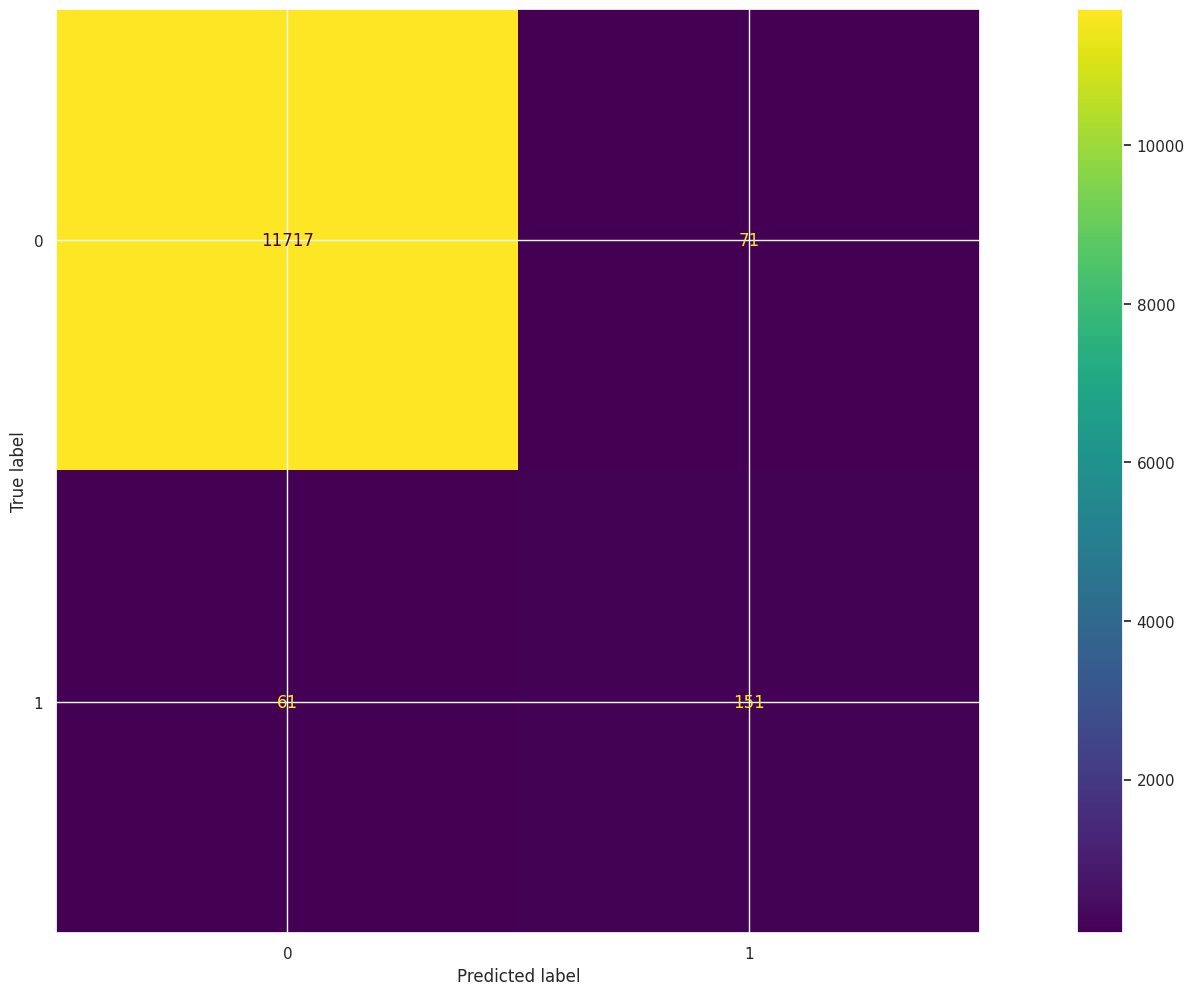

In [93]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train)
classification_metrics(knn,x_validation,y_validation)

### 7.1.1  KNN Cross Validation

In [94]:
knn_cv = cross_validation(knn,x_train,y_train,5,Verbose=False)

## 7.2 Logistic Regression 

/home/jordan/Estudismo/case_bix/case_tecnico/venv_truck/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model_Name,Recall,F1_Score,PRC AUC,AUC SCORE
0,LogisticRegression,0.6698,0.6469,0.7013,0.9703


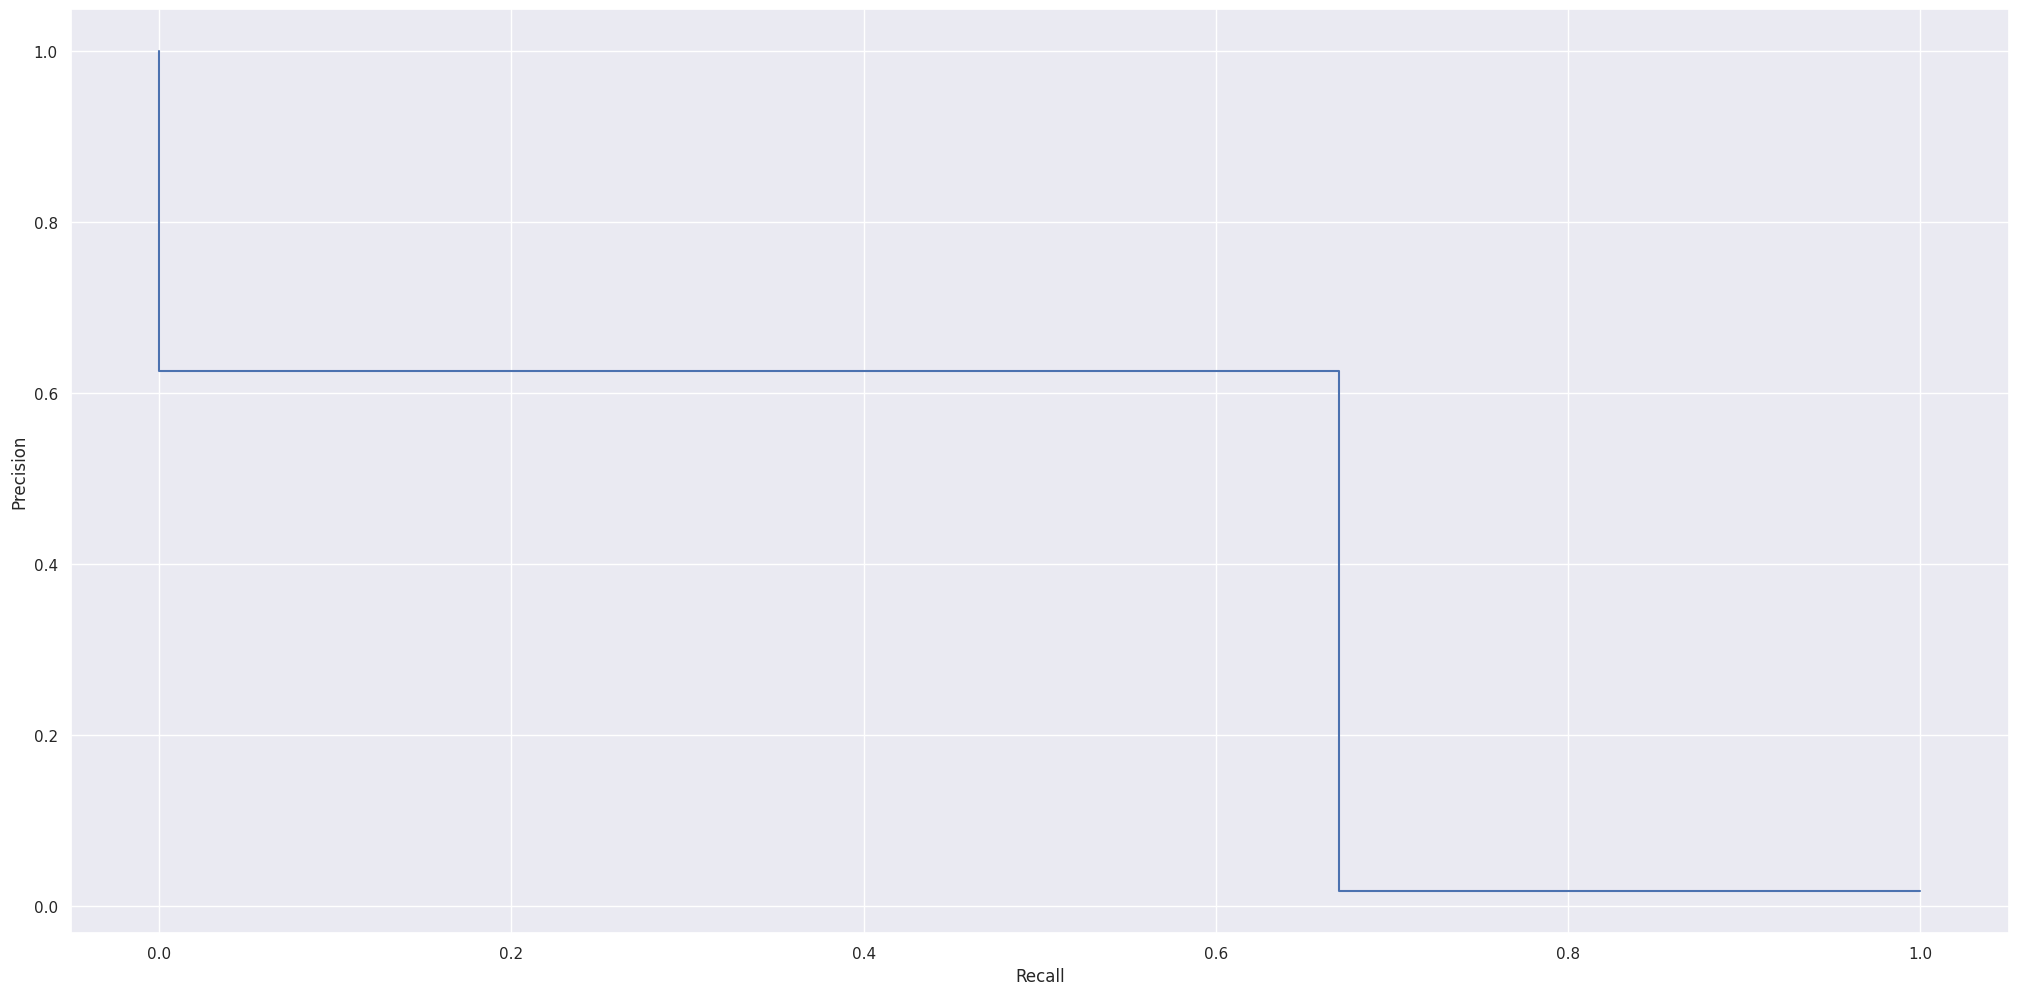

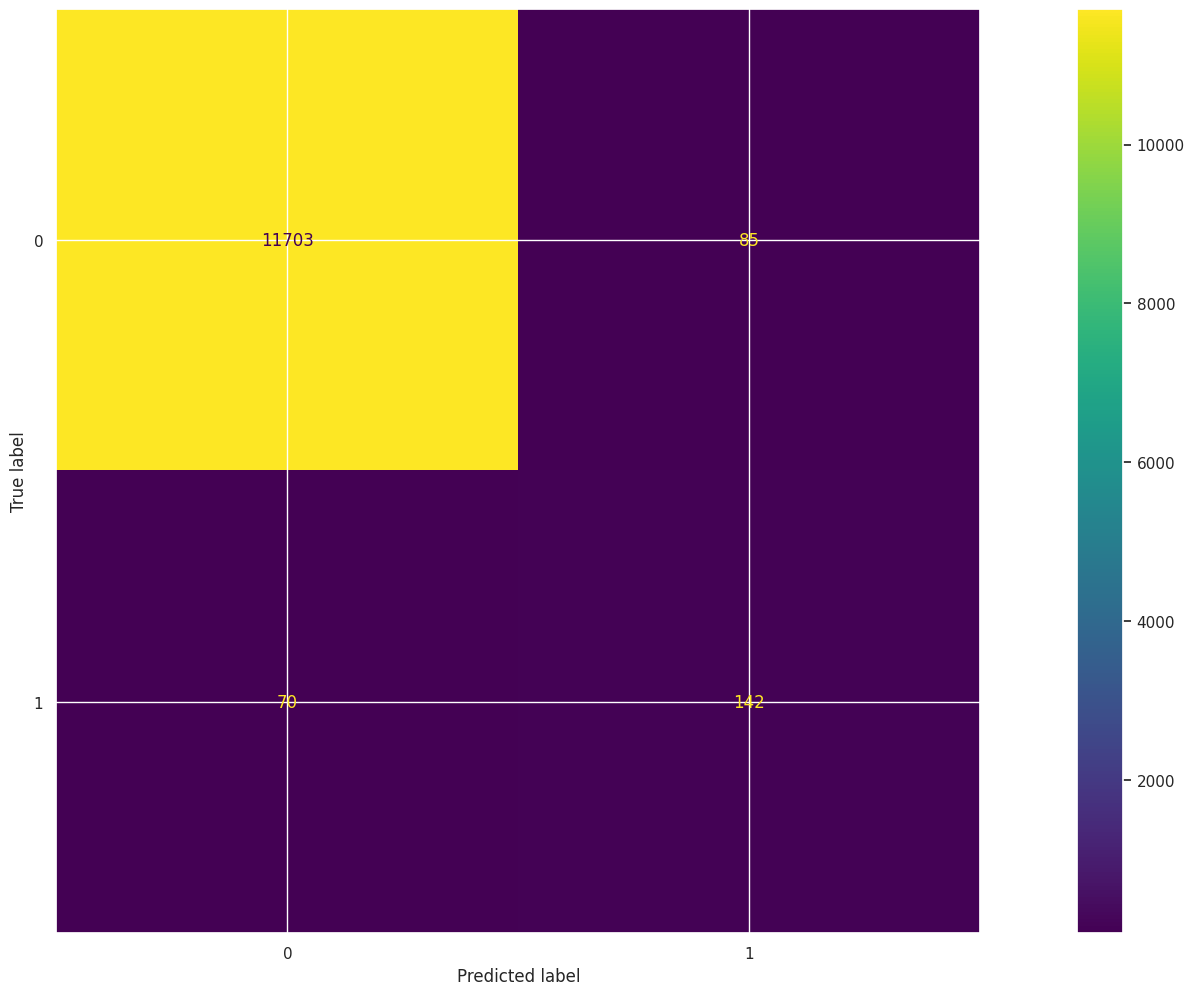

In [95]:
lr = LogisticRegression() 

lr.fit(x_train,y_train)
classification_metrics(lr,x_validation,y_validation)

### 7.2.1 Logistic Regression Cross Validation

In [96]:
lr_cv = cross_validation(lr,x_train,y_train,5,Verbose=False)

/home/jordan/Estudismo/case_bix/case_tecnico/venv_truck/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jordan/Estudismo/case_bix/case_tecnico/venv_truck/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

## 7.3 Random Forest Classifier

,Model_Name,Recall,F1_Score,PRC AUC,AUC SCORE
0,RandomForestClassifier,0.7877,0.7591,0.8252,0.9829


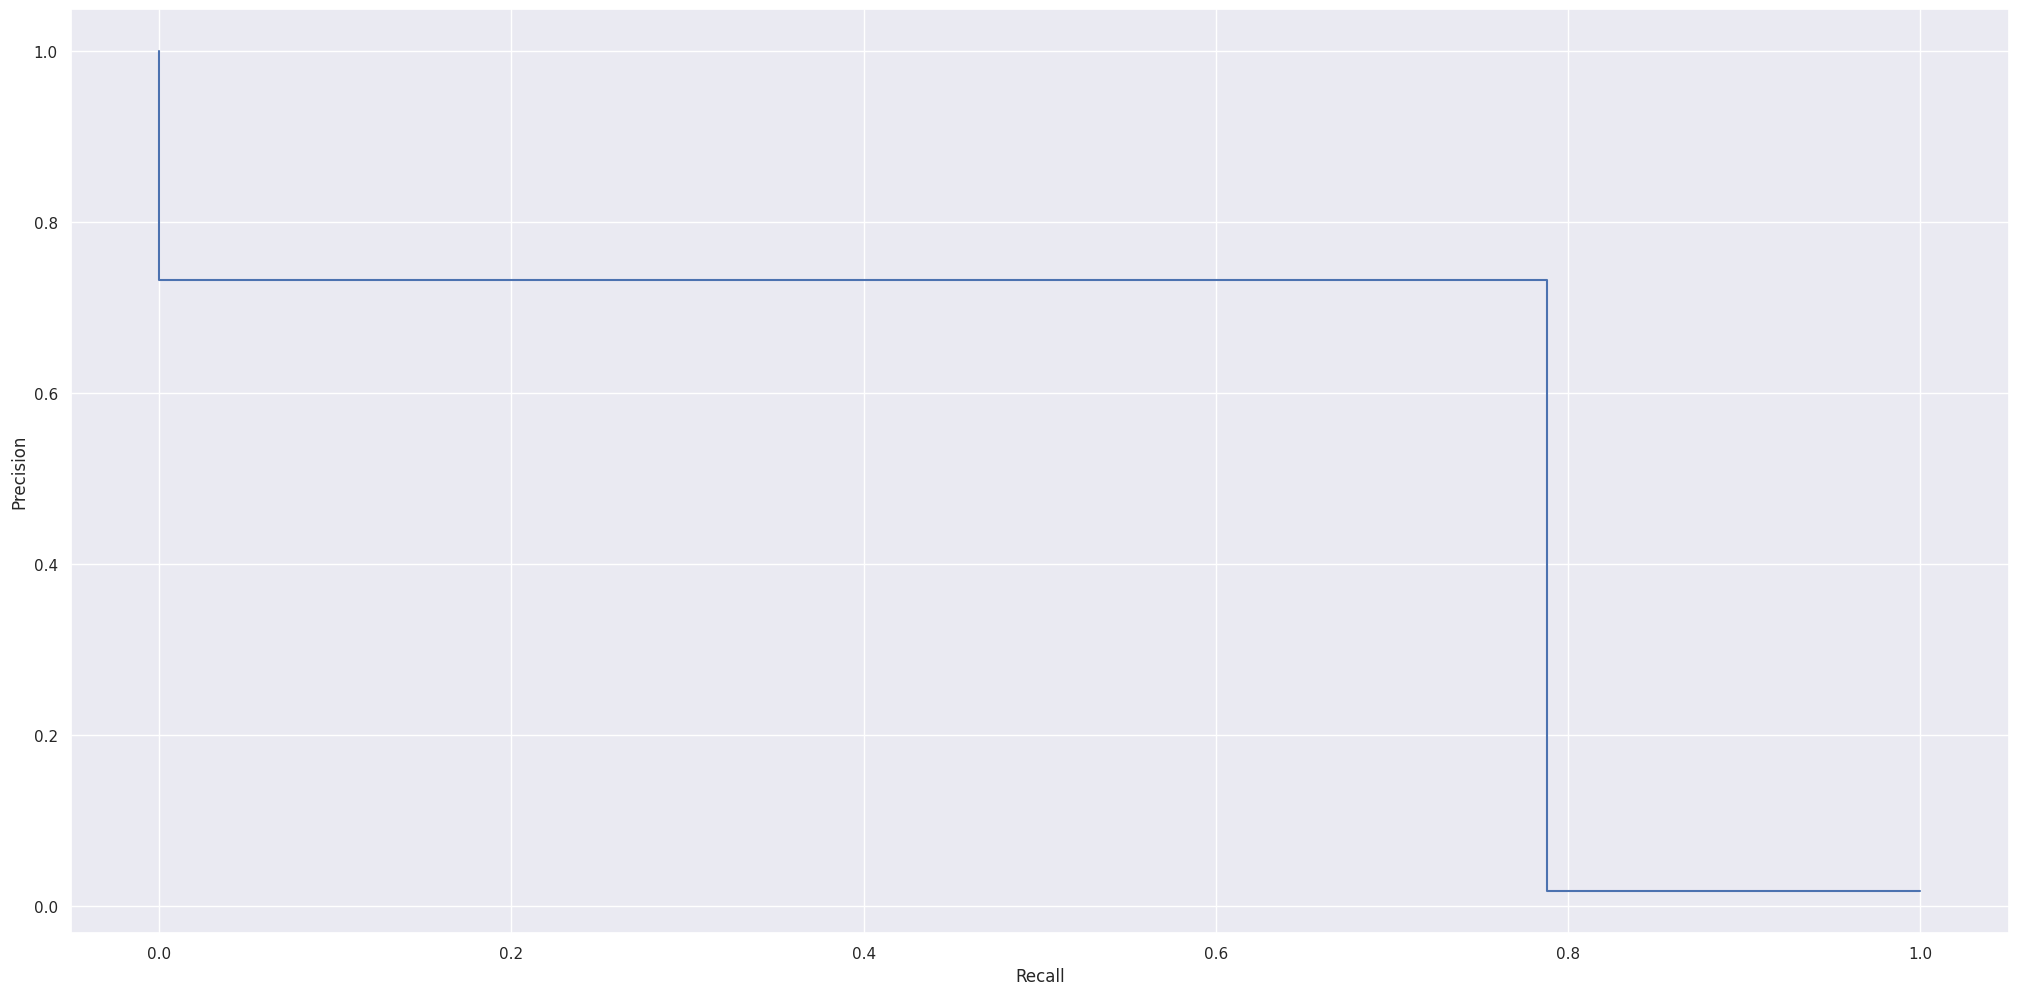

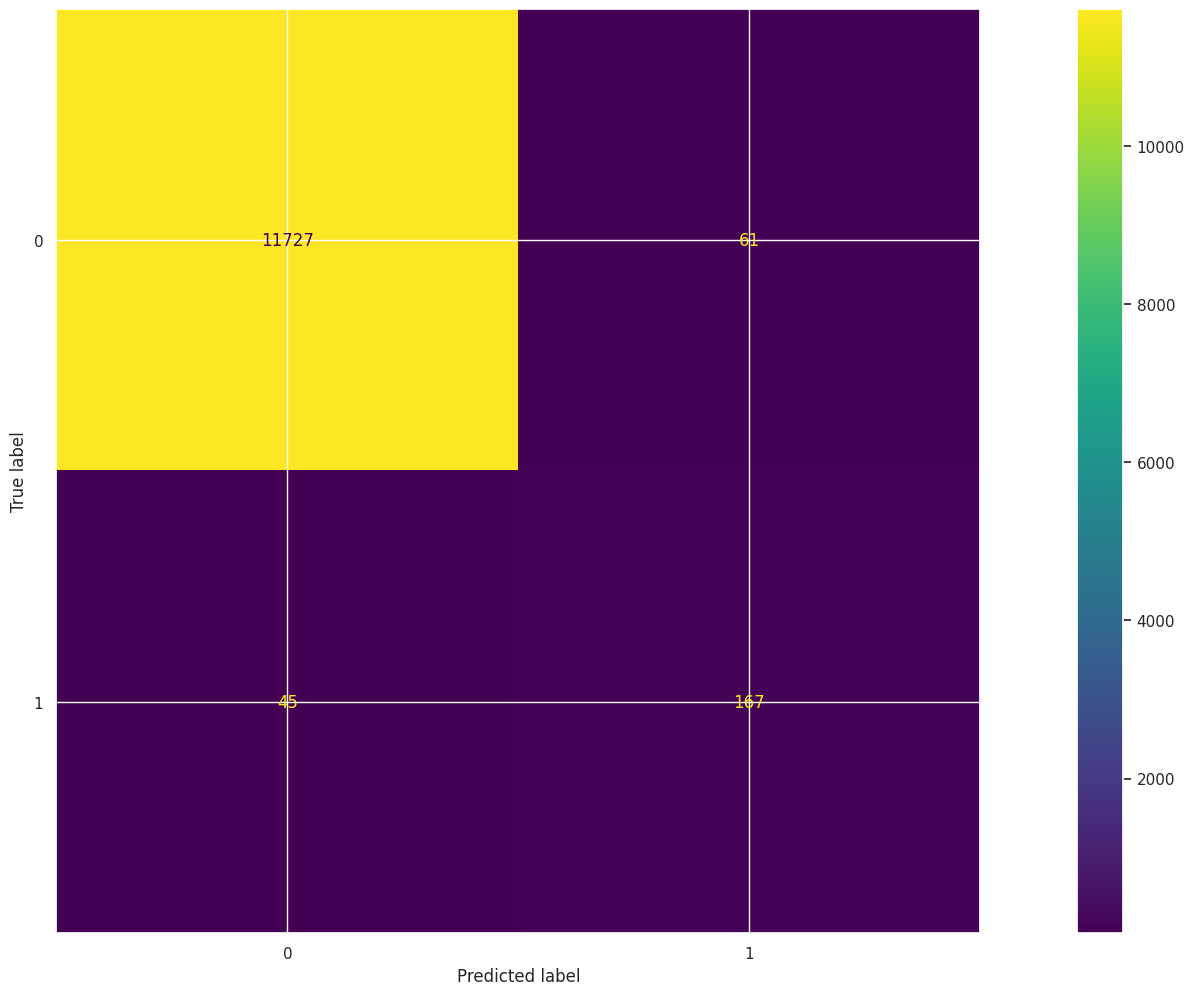

In [97]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(x_train,y_train)
classification_metrics(rf,x_validation,y_validation)


### 7.3.1 Random Forest CV

In [98]:
rf_cv = cross_validation(rf,x_train,y_train,5,Verbose=False)

## 7.4 LGBM Classifier

,Model_Name,Recall,F1_Score,PRC AUC,AUC SCORE
0,LGBMClassifier,0.8160,0.7706,0.8266,0.9880


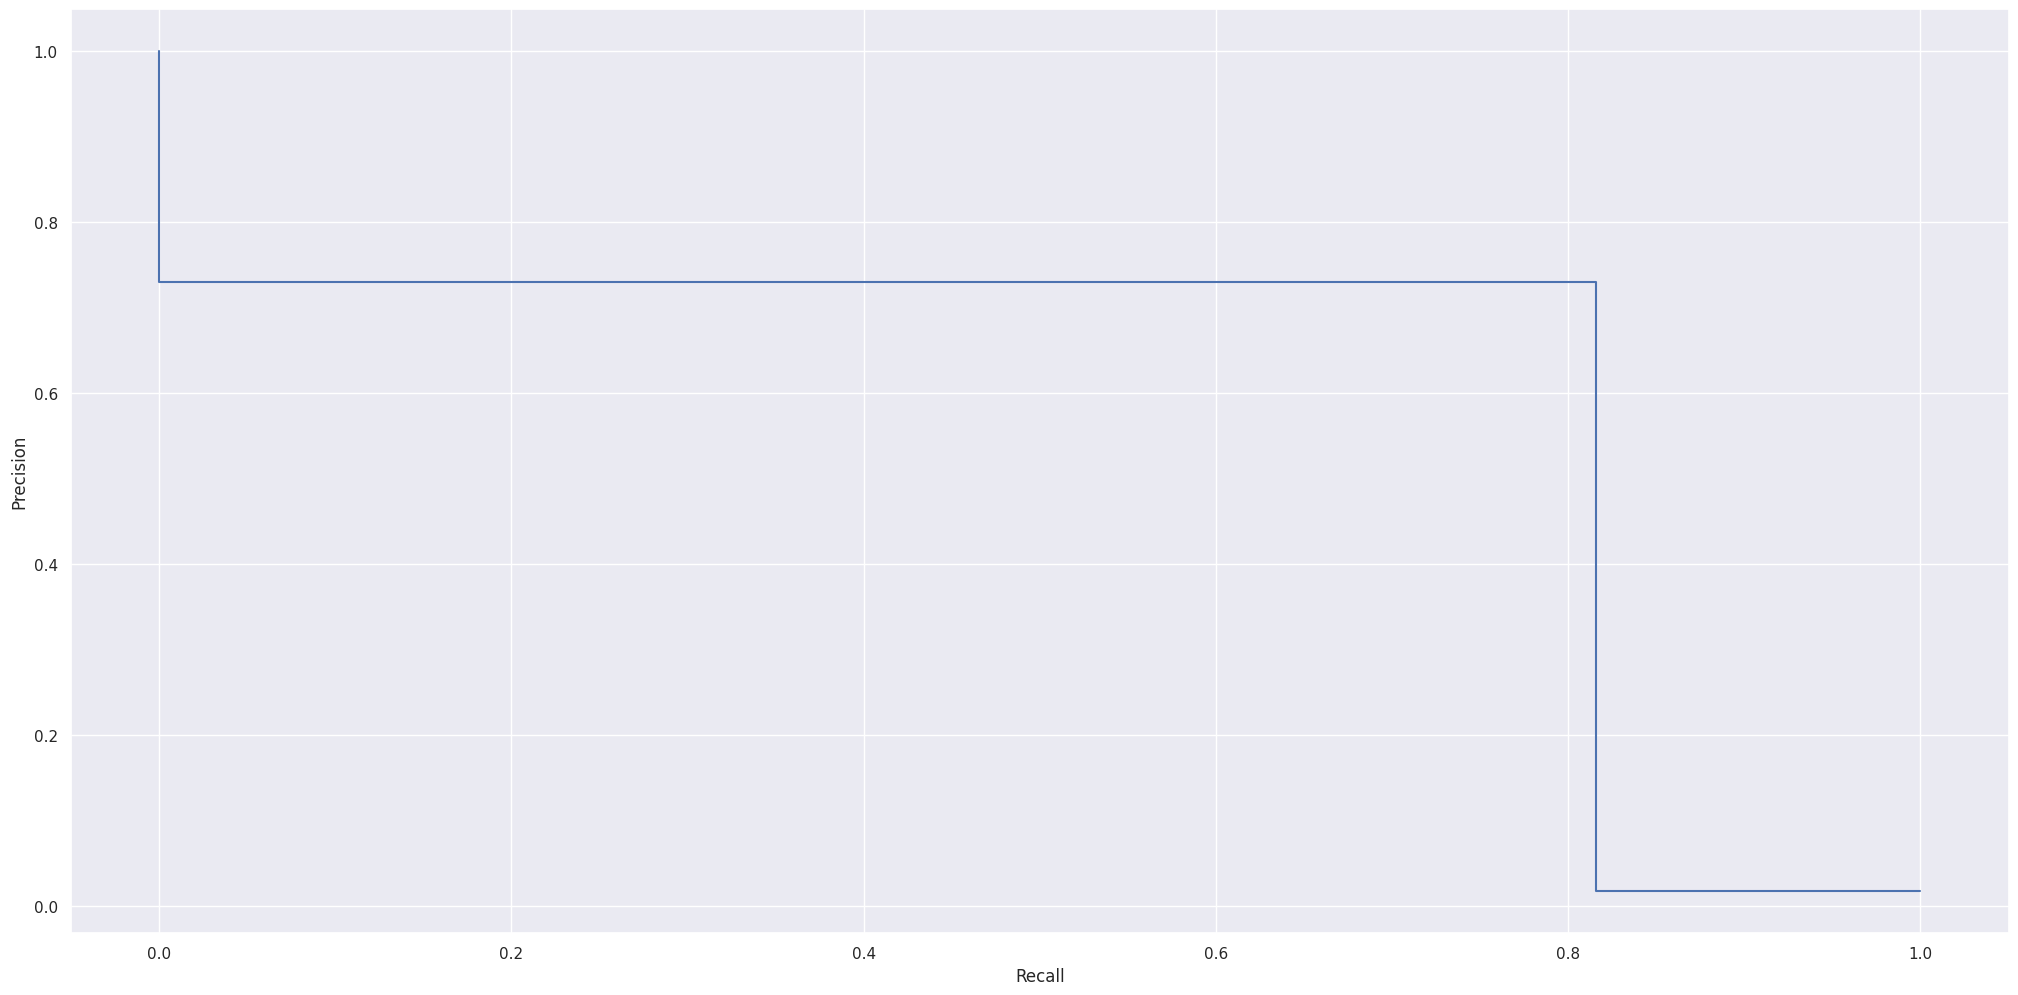

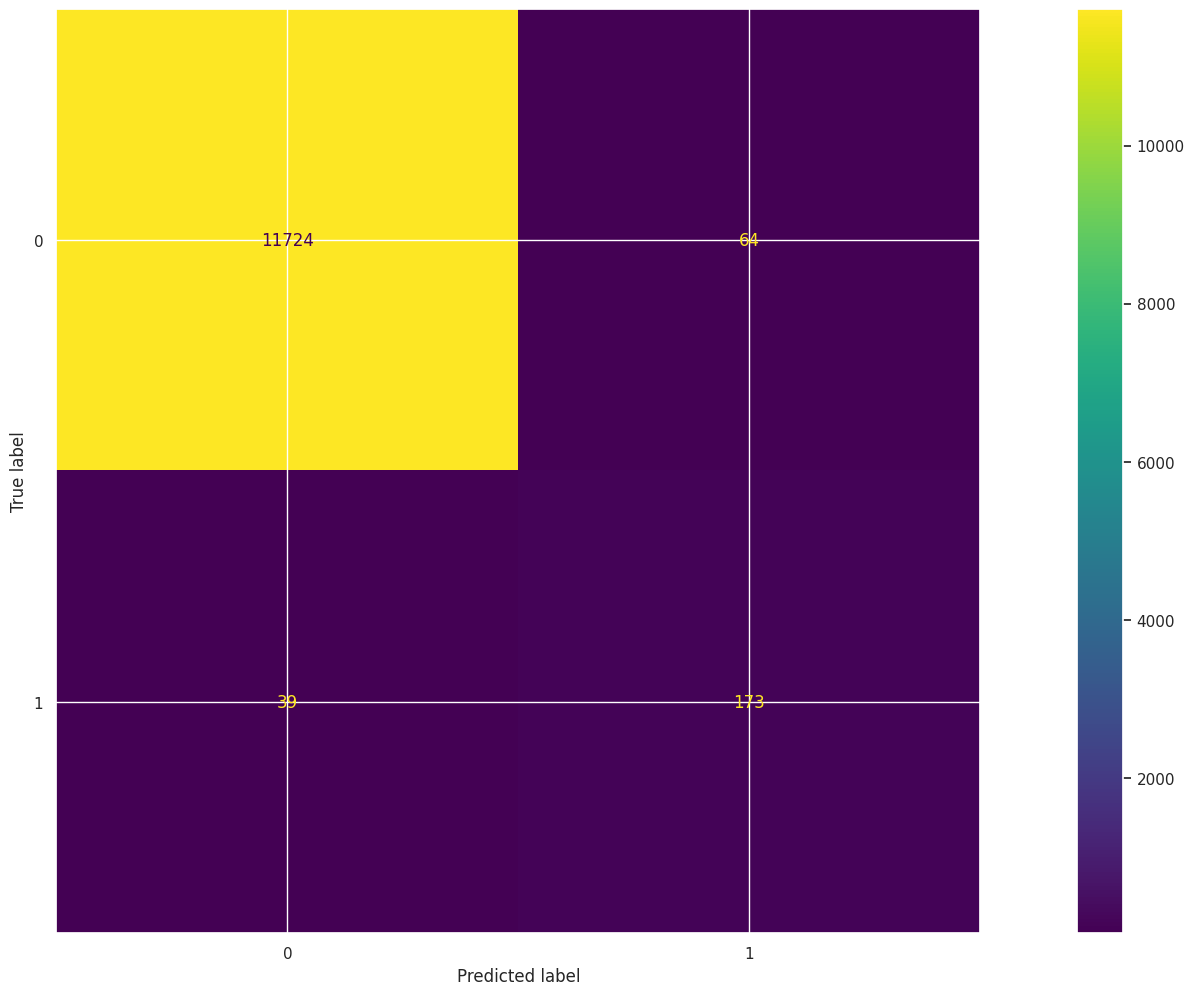

In [99]:
lgbm = LGBMClassifier()

lgbm.fit(x_train,y_train)
classification_metrics(lgbm,x_validation,y_validation)



### 7.4.1 LGBM Cross-Validation

In [100]:
lgbm_cv = cross_validation(lgbm,x_train,y_train,5,Verbose=False)

## 7.5 XGBoost Classifier

,Model_Name,Recall,F1_Score,PRC AUC,AUC SCORE
0,XGBClassifier,0.7877,0.7608,0.8264,0.9870


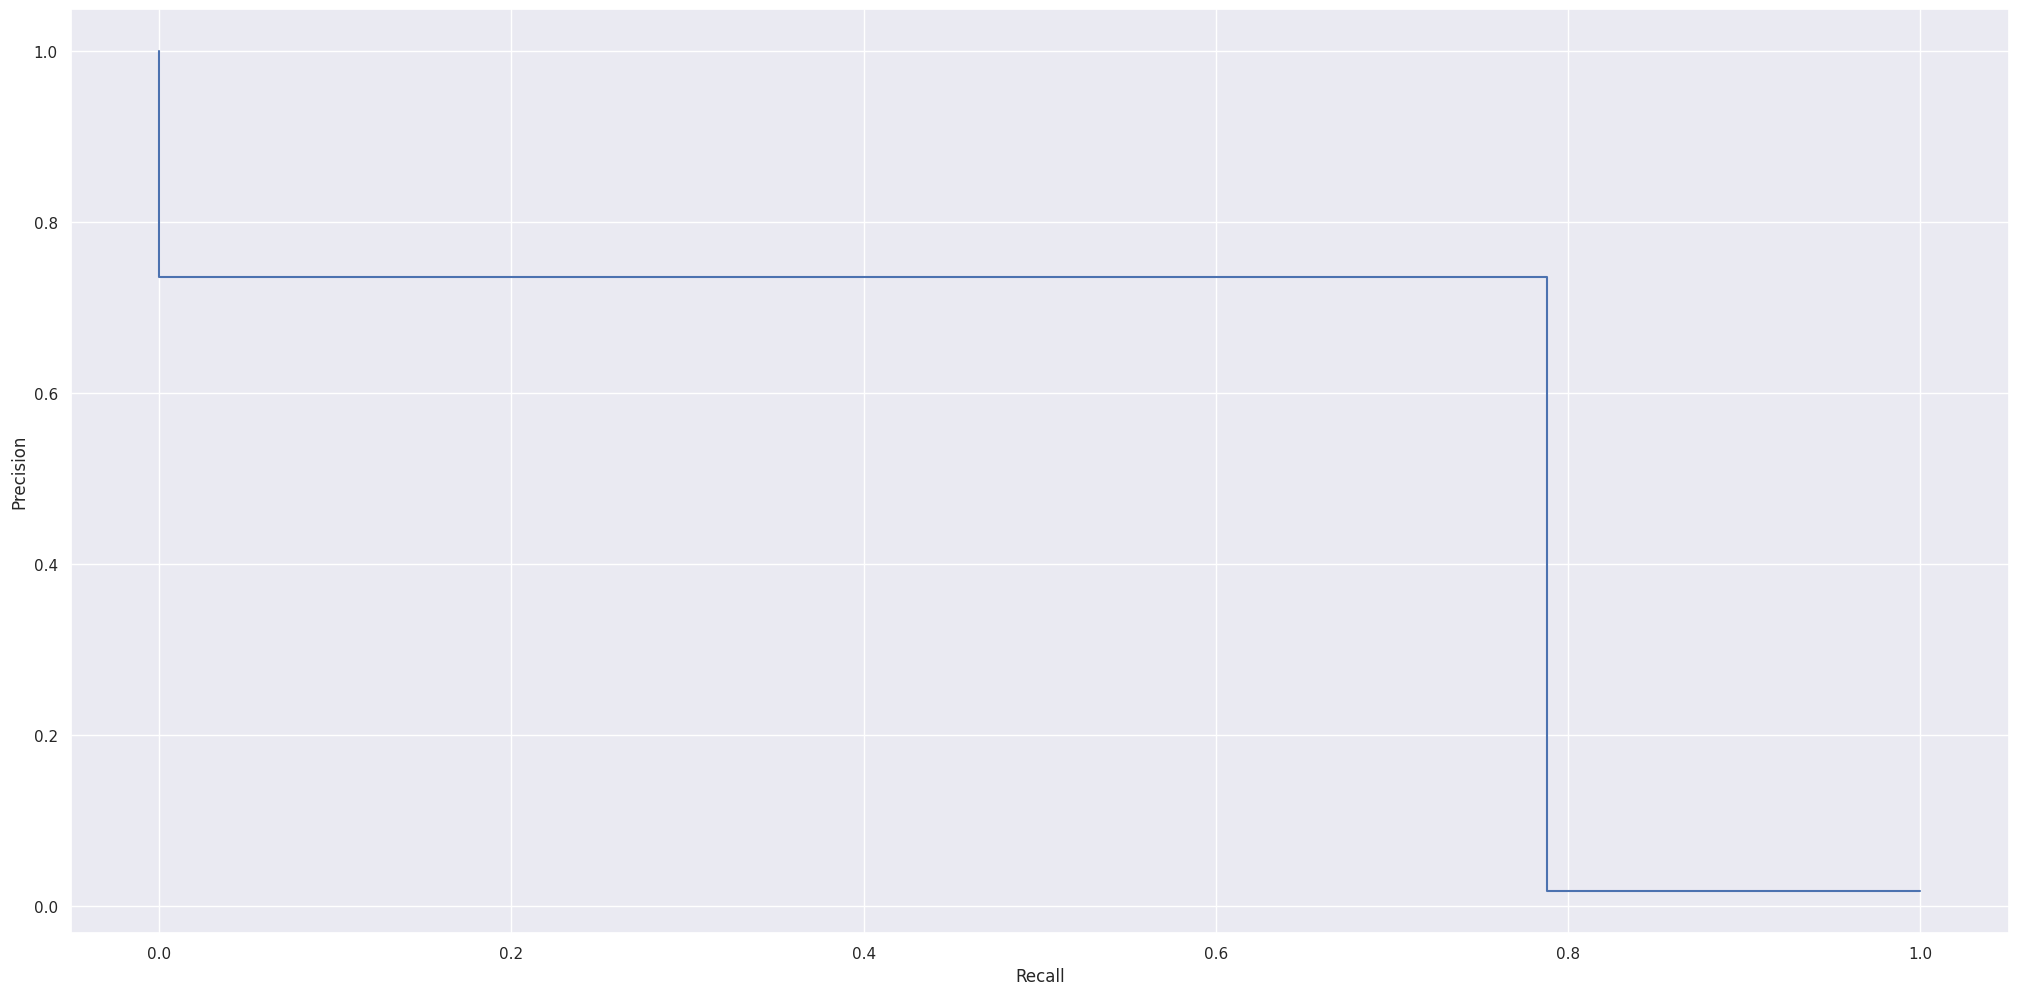

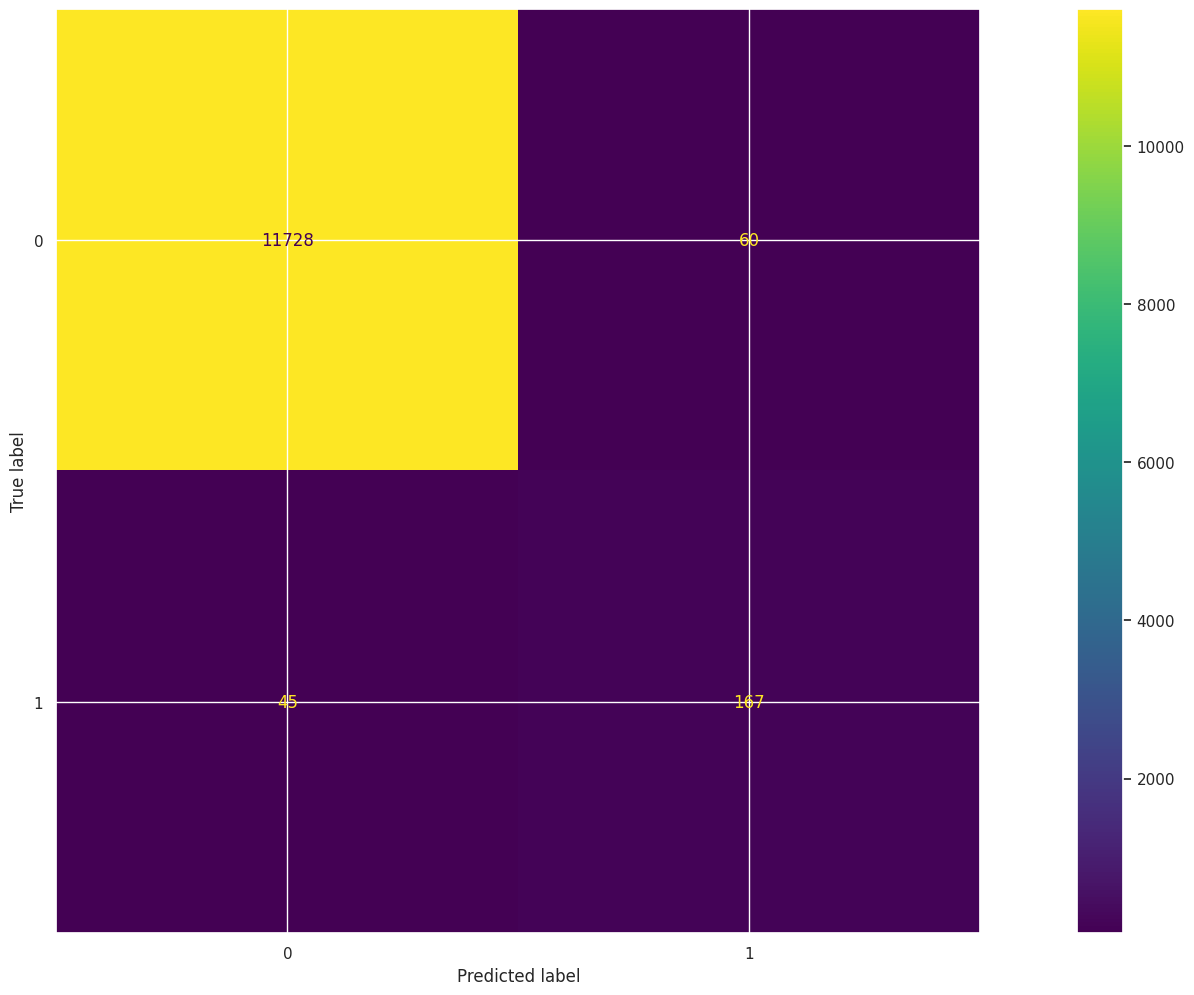

In [101]:
xgboost = XGBClassifier(n_jobs=-1)
xgboost.fit(x_train,y_train)

classification_metrics(xgboost,x_validation,y_validation)

In [102]:
xgb_cv = cross_validation(xgboost,x_train,y_train,5,Verbose=False)

## 7.6 Compare Model Perfomance


### 7.6.1 Real Perfomance - Cross Validation 

In [103]:
# FEATURE SELECTION (39) + STANDART SCALAR
model_results_cv = pd.DataFrame()
model_results_cv = pd.concat([knn_cv,lr_cv,rf_cv,lgbm_cv,xgb_cv]) 
model_results_cv.sort_values('PRC AUC',ascending=False)

,Model Name,Recall,F1 Score,PRC AUC,ROC AUC
0,XGBClassifier,0.8160,0.8647,0.9271,0.9917
0,RandomForestClassifier,0.8020,0.8598,0.9172,0.9881
0,LGBMClassifier,0.8160,0.8614,0.9132,0.9907
0,LogisticRegression,0.6802,0.7511,0.8176,0.9811
0,KNeighborsClassifier,0.7068,0.7899,0.7925,0.9388


# 8.0 Hyper Parameter Fine Tuning

In [106]:
import optuna

## 8.1 XGBoost 

In [104]:
# def xgb_objective(trial):
    
#     n_estimators_         = trial.suggest_int('n_estimators', 150,350)
#     eta_                  = trial.suggest_float('eta', 0.01,0.3)
#     max_depth_            = trial.suggest_int('max_depth',5,10)
#     subsample_            = trial.suggest_float('subsample',0.3,1.0)
#     colsample_bytree_     = trial.suggest_float('colsample_bytree',0.5,0.7)

    
#     model = XGBClassifier(n_estimators=n_estimators_,eta=eta_,max_depth=max_depth_,colsample_bytree=colsample_bytree_,subsample=subsample_).fit(x_train,y_train)
    
#     yhat_xgboost_proba =  model.predict_proba(x_validation)
#     yhat_xgboost = model.predict(x_validation)
    
#     # Metrics 
#     recall = recall_score(y_validation,yhat_xgboost)
    
#     # PRC AUC
#     prc_auc = average_precision_score(y_validation, yhat_xgboost_proba[:,1])
  
    
#     return recall

# study = optuna.create_study(direction='maximize')
# study.optimize(xgb_objective,n_trials=650)

# trial = study.best_trial

# print('Best Recall for XGBoost: {}'.format(trial.value))
# print('Best hyperparam: {}'.format(trial.params))

## 8.2 LGBM

In [88]:
# def lgbm_objective(trial):
    
# #     num_leaves = trial.suggest_int('num_leaves')
#     max_depth = trial.suggest_int('max_depth',3,8)
#     min_split_gain = trial.suggest_float('min_split_gain',0.01,0.1)
#     min_child_weight = trial.suggest_int('min_child_weight',10,50)
#     min_child_samples = trial.suggest_int('min_child_samples',1,7)
#     subsample = trial.suggest_float('subsample',0.1,1)
#     colsample_bytree = trial.suggest_float('colsample_bytree',0.1,1.0)
#     n_estimators = trial.suggest_int('n_estimators',100,500)
    
#     lgbm = LGBMClassifier(num_leaves= 2** max_depth,max_depth=max_depth,min_split_gain = min_split_gain,min_child_weight = min_child_weight,min_child_samples = min_child_samples,
#                           subsample = subsample ,colsample_bytree = colsample_bytree,n_estimators = n_estimators).fit(x_train,y_train)

    
#     yhat_lgbm_proba =  lgbm.predict_proba(x_validation)
#     yhat_lgbm = lgbm.predict(x_validation)
    
#     # Metrics 
#     recall = recall_score(y_validation,yhat_lgbm)
    
#     # PRC AUC
#     prc_auc = average_precision_score(y_validation, yhat_lgbm_proba[:,1])
    

#     return recall

# study = optuna.create_study(direction='maximize')
# study.optimize(lgbm_objective,n_trials=300);

# trial = study.best_trial

# print('Best Recall Score: {}'.format(trial.value))
# print('Best hyperparam: {}'.format(trial.params))

In [89]:
# Best hyperparam: {'max_depth': 7, 'min_split_gain': 0.0664109816983749, 'min_child_weight': 12, 'min_child_samples': 7, 'subsample': 0.5536618883344867, 'colsample_bytree': 0.6772316443912649, 'n_estimators': 500}

# 9.0 Final Model - Final Model XGBoost

## 9.1 Test Dataset Transformation


In [105]:
df_test = pd.read_csv('../data/air_system_present_year.csv')

In [106]:
df_test['class'].value_counts()

neg    15625
pos      375
Name: class, dtype: int64

In [107]:
df_test = df_test.replace('na','0')
df_test = df_test.astype({col: float for col in df1.columns[1:]})
df_test['class'] = df_test['class'].apply(lambda x: 1 if x == 'pos' else 0)

In [108]:
x_test = df_test.drop(['class'],axis=1)
y_test = df_test['class']

In [109]:
x_test.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0000,0.0000,20.0000,12.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2682.0000,4736.0000,3862.0000,1846.0000,0.0000,0.0000,0.0000,3976.0000,0.0000,0.0000,0.0000,1520.0000,2374.0000,11516.0000,9480.0000,111258.0000,470.0000,0.0000,0.0000,0.0000,0.0000,58.0000,26.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,13124.0000,2.0000,1956.0000,434.0000,76.0000,174.0000,190.0000,6198.0000,1148.0000,2948.0000,2.0000,0.0000,8762.0000,2566.0000,480.0000,380.0000,196.0000,516.0000,86.0000,66.0000,74.0000,0.0000,124340.0000,4.0000,6.0000,4.0000,0.0000,3976.0000,318.0000,107662.0000,3458.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,110980.0000,59.5300,124340.0000,124340.0000,184970.0000,54.0000,686.0000,12246.0000,123880.0000,13196.0000,1209600.0000,598.0000,0.0000,6.0000,0.0000,5913.6000,0.0000,5851.2000,6.0000,30.0000,0.0000,2.0000,5512.0000,4674.0000,1388.0000,1508.0000,38.0000,4.0000,0.0000,0.0000,8.0000,12.0000,124340.0000,0.0000,1550.0000,14.0000,36.0000,26.0000,920.0000,430.0000,7650.0000,2294.0000,206.0000,0.0000,22.0000,42.0000,5336.0000,1276.0000,0.0000,0.0000,0.0000,0.0000,6598.0000,70.0000,112.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,340.0000,0.0000,0.0000,1100.0000,574.0000,232.0000,66.0000,780.0000,882.0000,0.0000,4.0000,0.0000,0.0000,0.0000,465.5000,90.0000,7502.0000,3156.0000,1098.0000,138.0000,412.0000,654.0000,78.0000,88.0000,0.0000,0.0000,0.0000,0.0000
1,82.0000,0.0000,68.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,748.0000,12594.0000,3636.0000,0.0000,0.0000,0.0000,5244.0000,0.0000,60.0000,0.0000,0.0000,0.0000,23174.0000,18166.0000,23686.0000,1270.0000,0.0000,0.0000,0.0000,0.0000,12.0000,82.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,692.0000,16286.0000,0.0000,280.0000,44.0000,50.0000,1274.0000,866.0000,3362.0000,11102.0000,0.0000,0.0000,0.0000,12564.0000,1756.0000,638.0000,276.0000,172.0000,132.0000,812.0000,308.0000,192.0000,128.0000,46894.0000,4.0000,2.0000,38.0000,0.0000,5244.0000,360.0000,20520.0000,3134.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,23320.0000,81.8900,46894.0000,46894.0000,48324.0000,68.0000,0.0000,4486.0000,46480.0000,17050.0000,1209600.0000,726.0000,2.0000,4.0000,0.0000,7224.9600,0.0000,7768.3200,0.0000,42.0000,0.0000,0.0000,4.0000,7064.0000,6200.0000,2452.0000,1246.0000,12.0000,0.0000,0.0000,14.0000,54.0000,46894.0000,0.0000,2202.0000,28.0000,114.0000,350.0000,700.0000,1708.0000,9622.0000,2174.0000,80.0000,0.0000,80.0000,206.0000,7802.0000,1466.0000,0.0000,0.0000,0.0000,0.0000,7918.0000,78.0000,40.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,352.0000,0.0000,0.0000,3996.0000,584.0000,200.0000,62.0000,37580.0000,3756.0000,6368.0000,36.0000,0.0000,0.0000,0.0000,2.8600,102.0000,10040.0000,3310.0000,1068.0000,276.0000,1620.0000,116.0000,86.

## 9.2 Scaling Test Dataset

In [110]:
x_test_scaler = sc.transform(x_test)


In [111]:
x_test_final = pd.DataFrame(x_test_scaler,columns=x_test.columns)
x_test_final = x_test_final[cols_selected]

In [112]:
# x_test_final[333] = (x_validation[94] + x_validation[70] )/ 2

In [113]:
# Join Train + Validation for Final Training
x_train_final = pd.concat([x_train,x_validation],axis=0)
y_train_final = pd.concat([y_train,y_validation],axis=0)

## 9.3 Final Model

### 9.3.1 XGBoost

In [114]:
# param_xgb_tuned = {'n_estimators': 243, 'eta': 0.23752456927789523, 'max_depth': 8, 'subsample': 0.49558498541460394, 'colsample_bytree': 0.5309650593210631} # 49
# param_xgb_tuned = {'n_estimators': 271, 'eta': 0.2768211631353418, 'max_depth': 6, 'subsample': 0.9505407737577138, 'colsample_bytree': 0.555703381978301} # 53

In [115]:
param_xgb_tuned = {'n_estimators': 254, 'eta': 0.1805009334625665, 'max_depth': 5, 'subsample': 0.41067293045952674, 'colsample_bytree': 0.6994352509806072} # 46
# param_xgb_tuned = {'n_estimators': 152, 'eta': 0.1513936729269941, 'max_depth': 9, 'subsample': 0.5858796496604519, 'colsample_bytree': 0.6296180600365582} # 47

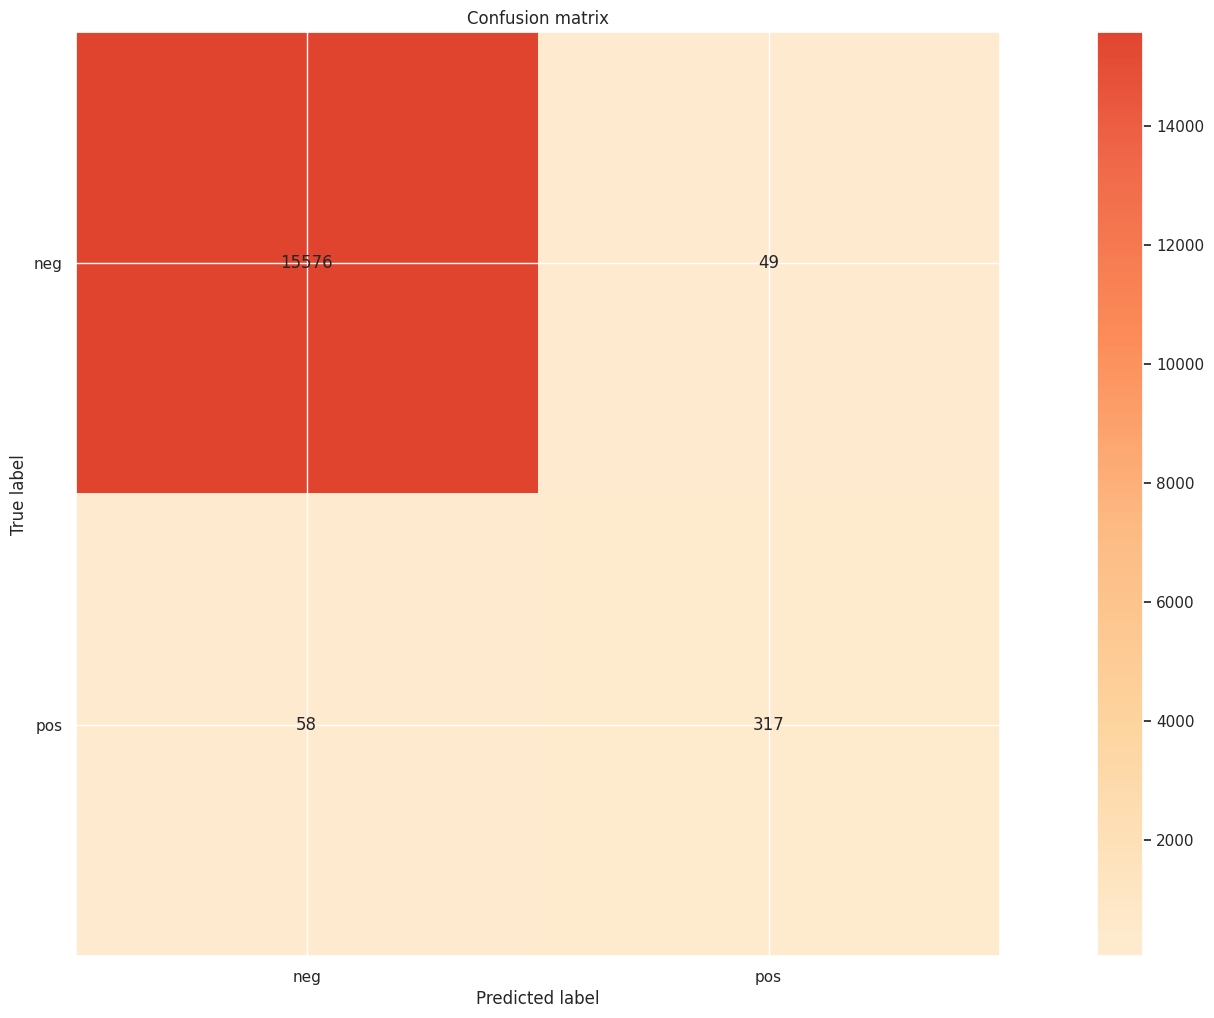

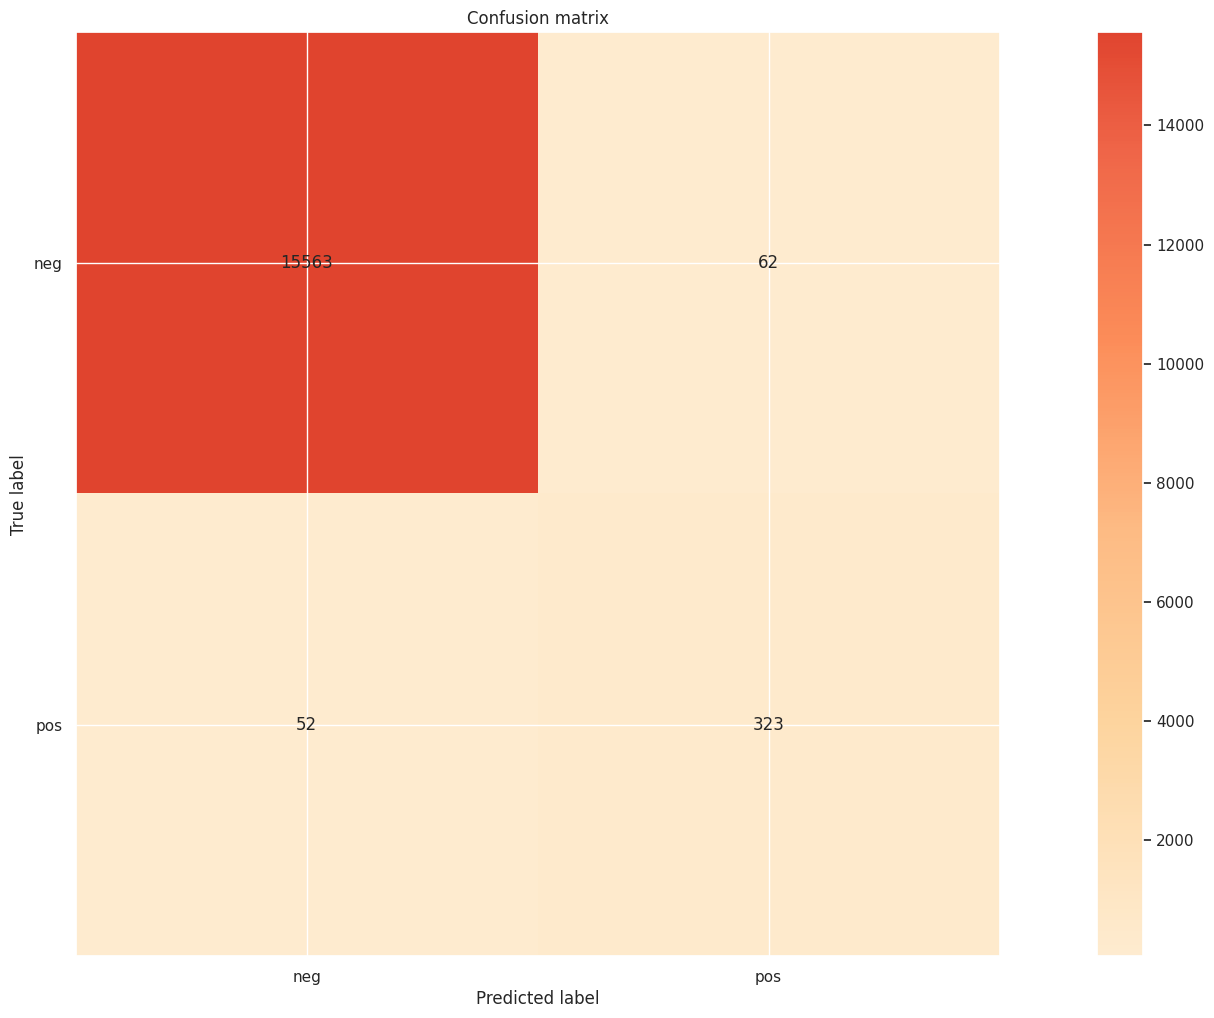

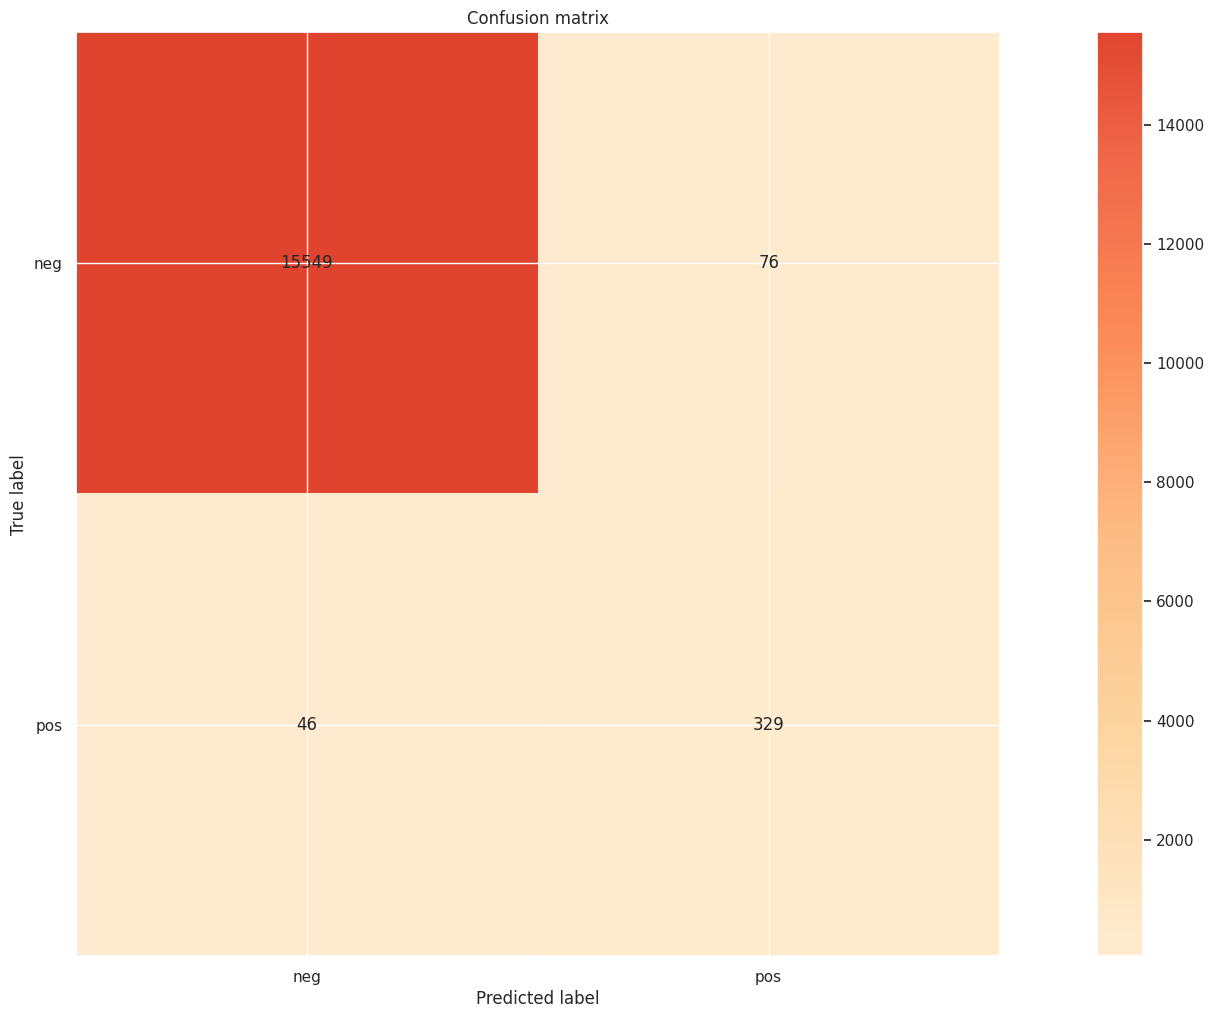

In [116]:
xgb = XGBClassifier(n_estimators= param_xgb_tuned['n_estimators'], eta= param_xgb_tuned['eta'], max_depth= param_xgb_tuned['max_depth'], 
                    subsample= param_xgb_tuned['subsample'], colsample_bytree= param_xgb_tuned['colsample_bytree']).fit(x_train_final,y_train_final)


yhat = xgb.predict(x_test_final)
yhat_proba =  xgb.predict_proba(x_test_final) 



# Confusion Matrix
# Without selected Threshold
cm_threshold = plot.ConfusionMatrix.from_raw_data(y_test, yhat ,target_names = ['neg', 'pos'])

# Threshold 0.4 and 0.3 
cm_threshold_1 = plot.ConfusionMatrix.from_raw_data(y_test, yhat_proba[:,1] >= 0.4,target_names = ['neg', 'pos'])
cm_threshold_2 = plot.ConfusionMatrix.from_raw_data(y_test, yhat_proba[:,1] >= 0.3,target_names = ['neg', 'pos'])



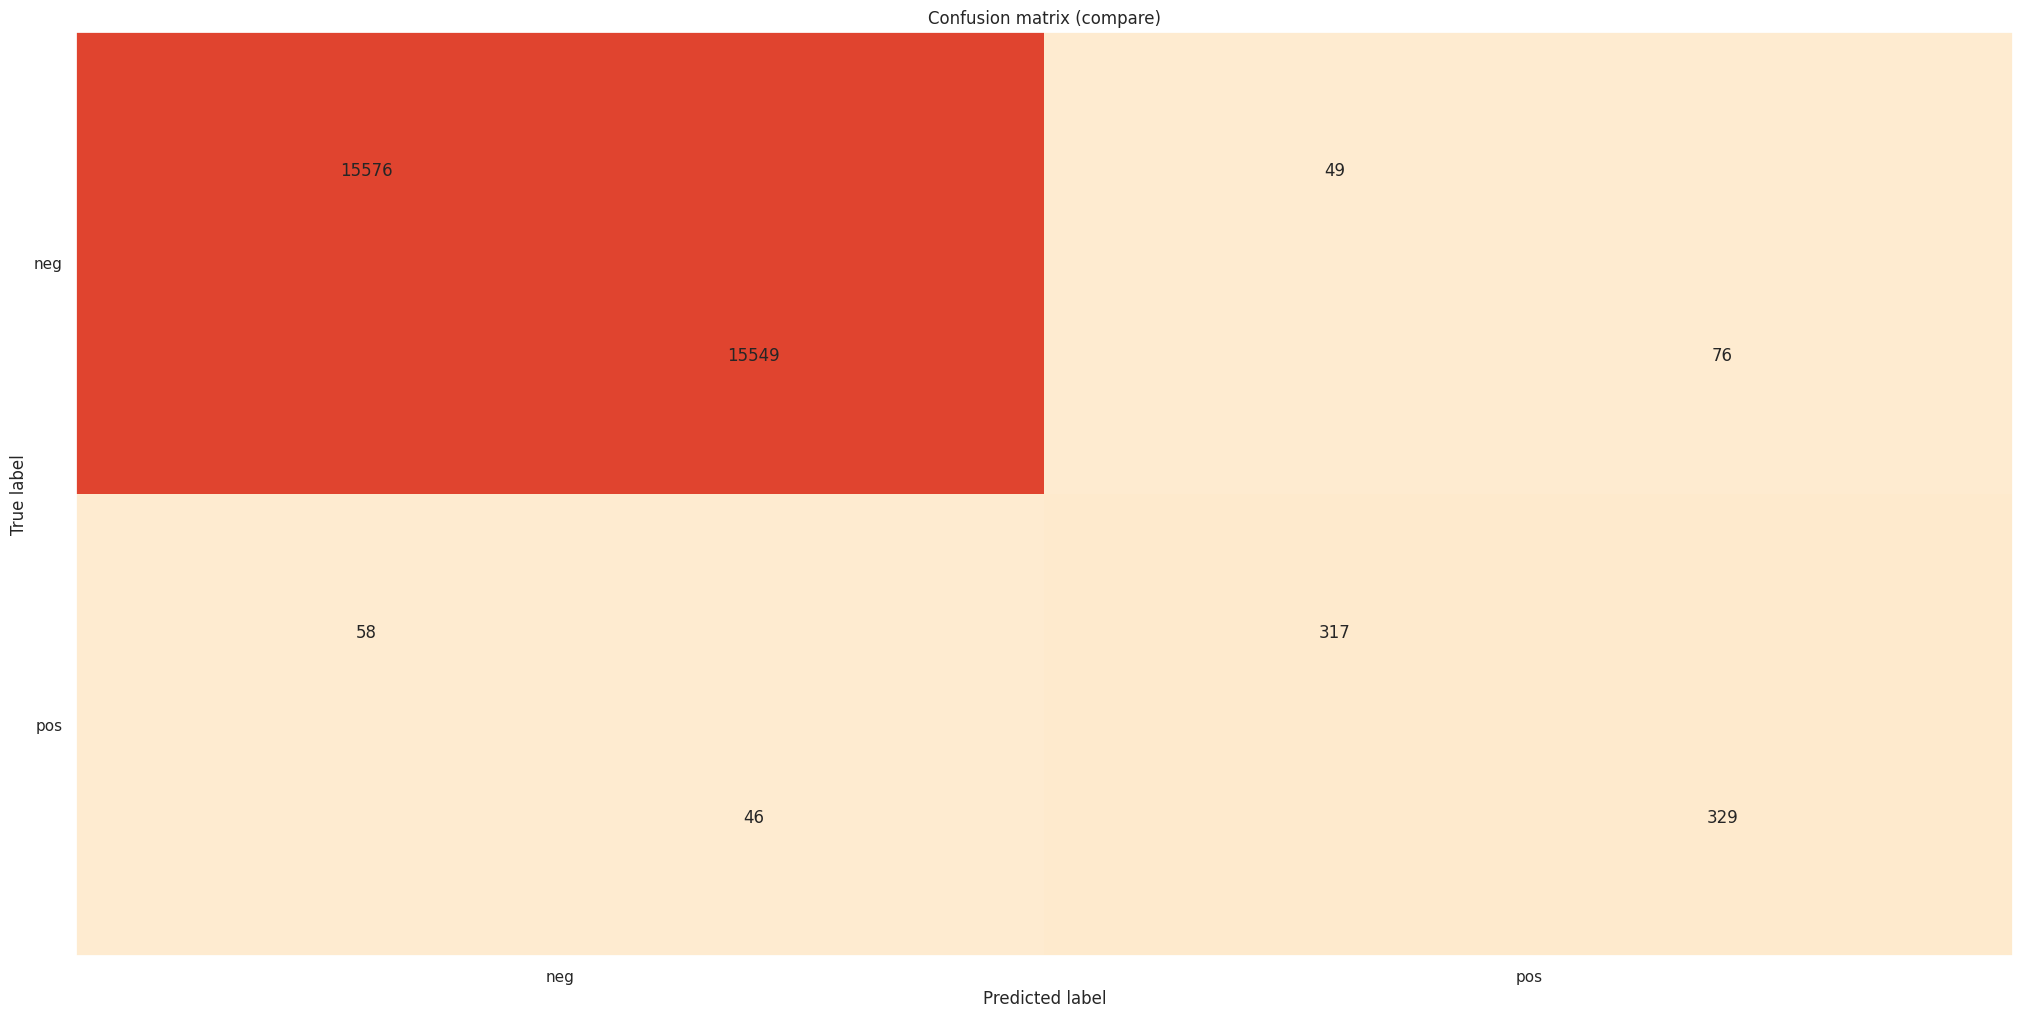

In [117]:
cm_threshold + cm_threshold_2;

# 10. Resultados de Negócio

## 10.0 Perguntas de Negócio

No início do projeto as seguintes perguntas de negócios foram feitas:

* Conseguimos diminuir nossos gastos com este tipo de manutenção(sistema de ar) utilizando técnicas de AI?
* Você consegue me apresentar os principais fatores que alertam uma possível falha neste sistema?

Nas seguintes seções nós iremos responder a essas perguntas e explicar um pouco mais sobre como foi feita essa análise

    

## 10.1 Tradução do Modelo para Negócio

Para analisarmos a tradução para negócio, iremos nos utilizar da Matriz de Confusão gerada pelo modelo atrelada ao conhecimento do contexto de negócio:

**Matriz de Confusão**

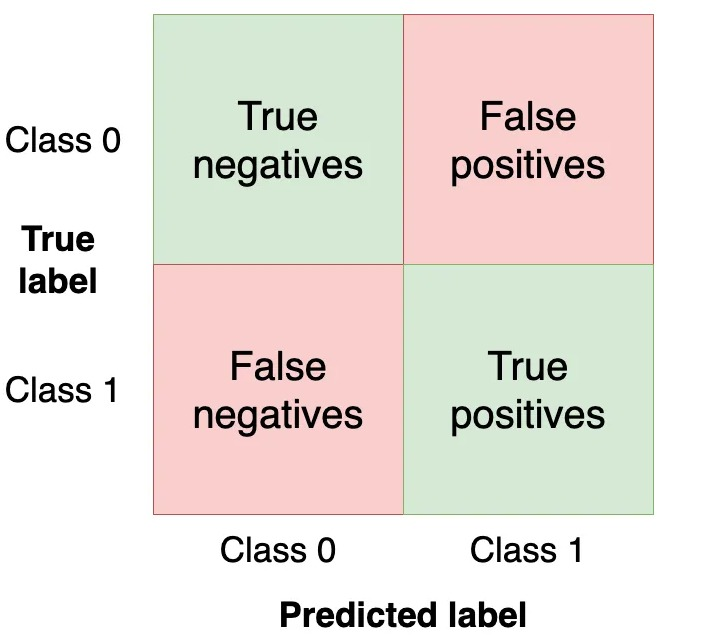

In [118]:
Image('../images/confusion_matrix.jpeg')

* TN (True Negative): Não apresenta problema no sistema de ar e nosso modelo preve corretamente.
* FP (False Positive): Não apresenta problema no sistema de ar e nosso modelo não preve corretamente.
* FN (False Negative): Apresenta problema no sistema de ar e nosso modelo não preve corretamente.
* TP (True Positive): Apresenta problema no sistema de ar e nosso modelo preve corretamente.

**Premissa de Negócio**

Antes de traduzir esses valores para custos, nós iremos assumir a premissa de que caminhões com classificação errada mas não possuem problemas no sistema de ar (FP) são somente vistoriados, gerando assim um valor apenas de 10$.

Baseando no contexto e premissas de negócio esse valores podem ser traduzidos em custo, no qual:

* TN : Custo é 10x o número de caminhões.  -> valor cobrado pelo tempo gasto durante a vistoria especializada.
* FP : Custo é 10x o número de caminhões.  -> valor cobrado pelo tempo gasto durante a vistoria especializada.
* FN : Custo é 500x o número de caminhões. -> valor cobrado pela manutenção corretiva.
* TP : Custo é 25x o número de caminhões.  -> valor cobrado pela manuntenção preventiva.



## 10.2 Tradução em Valor de Custo ($)

Utilizando então a Matriz de Confusão para traduzir os valores em custo($) temos que:

TN: 15549, FN: 46, FP:76, TP:329
Custo Total de manutenção com os sistema de ar :$31225.00


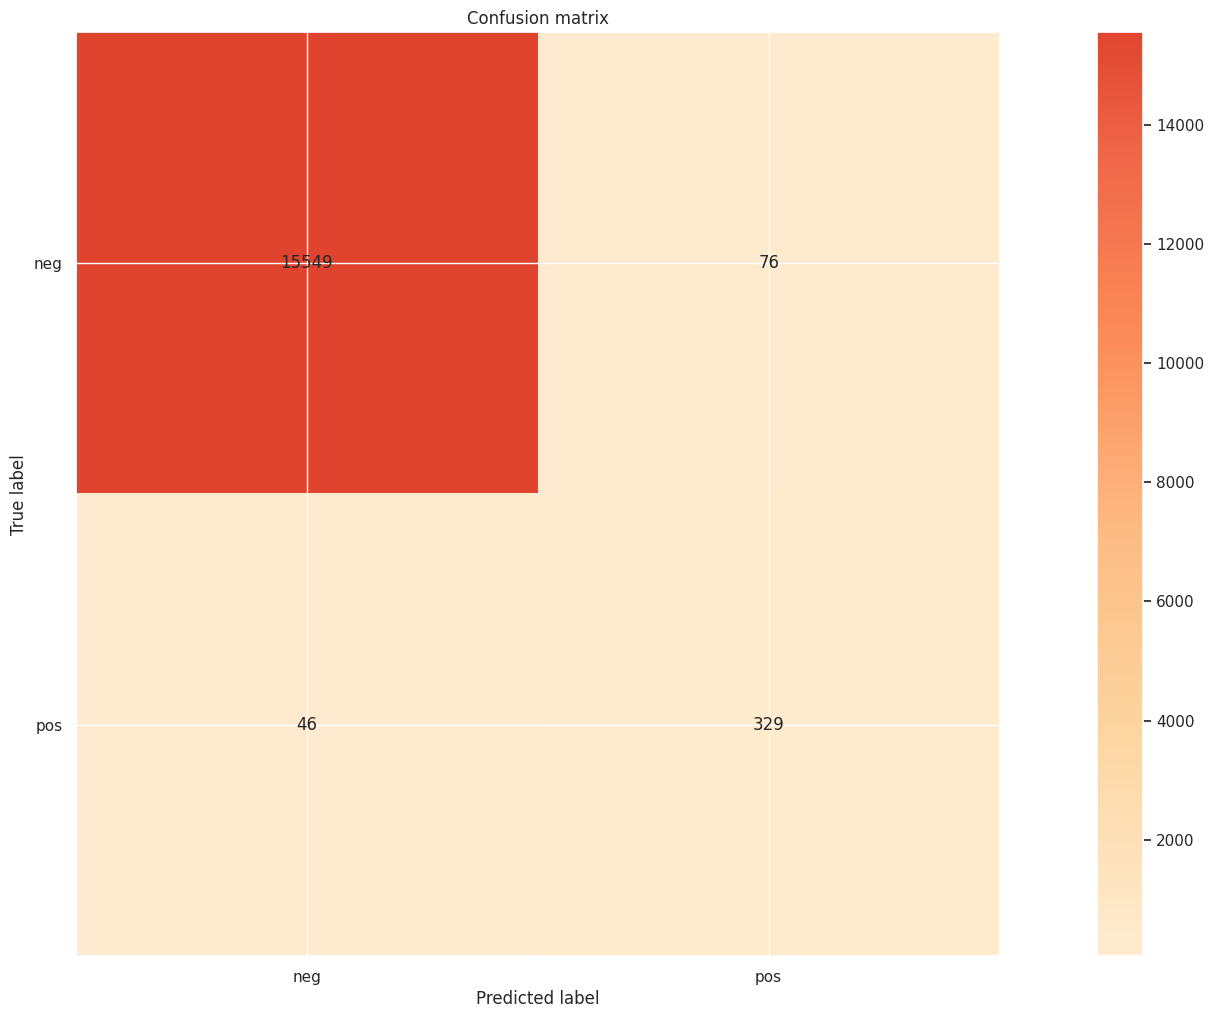

In [119]:
cm_threshold_2 = plot.ConfusionMatrix.from_raw_data(y_test, yhat_proba[:,1] >= 0.3,target_names = ['neg', 'pos'])
custo_ar = (46*500) + (329*25)

print('TN: 15549, FN: 46, FP:76, TP:329')
print('Custo Total de manutenção com os sistema de ar :${:.2f}'.format(custo_ar))
      

<!-- * R1. Portanto, para o nosso segundo ciclo desenvolvemos um modelo alternativo utilizando XGBoost e Padronizando os dados e já conseguimos cortar pela metade o custo se comparado ao baseline que haviámos criado no ciclo passado. -->

## 10.3 Impacto Financeiro Gerado ( Redução de Custos)

Utilizando então a base de dados da manutenção para o ano presente, podemos obter a seguinte comparação:

- Custo Total da Empresa com sistema de ar segundo descrição do negócio :  *$37.000.00*


- Custo Total com sistema de ar utilizando Modelo de ML Sugerido:  *$31.225.00*


- Economia Gerada utilizando modelo Sugerido:  **$5.775,00**



In [120]:
df_impacto = pd.DataFrame({ 'Tipo'   : ['Modelo Atual','Modelo ML'],
                           'Custo($)' : [37000,31225]})

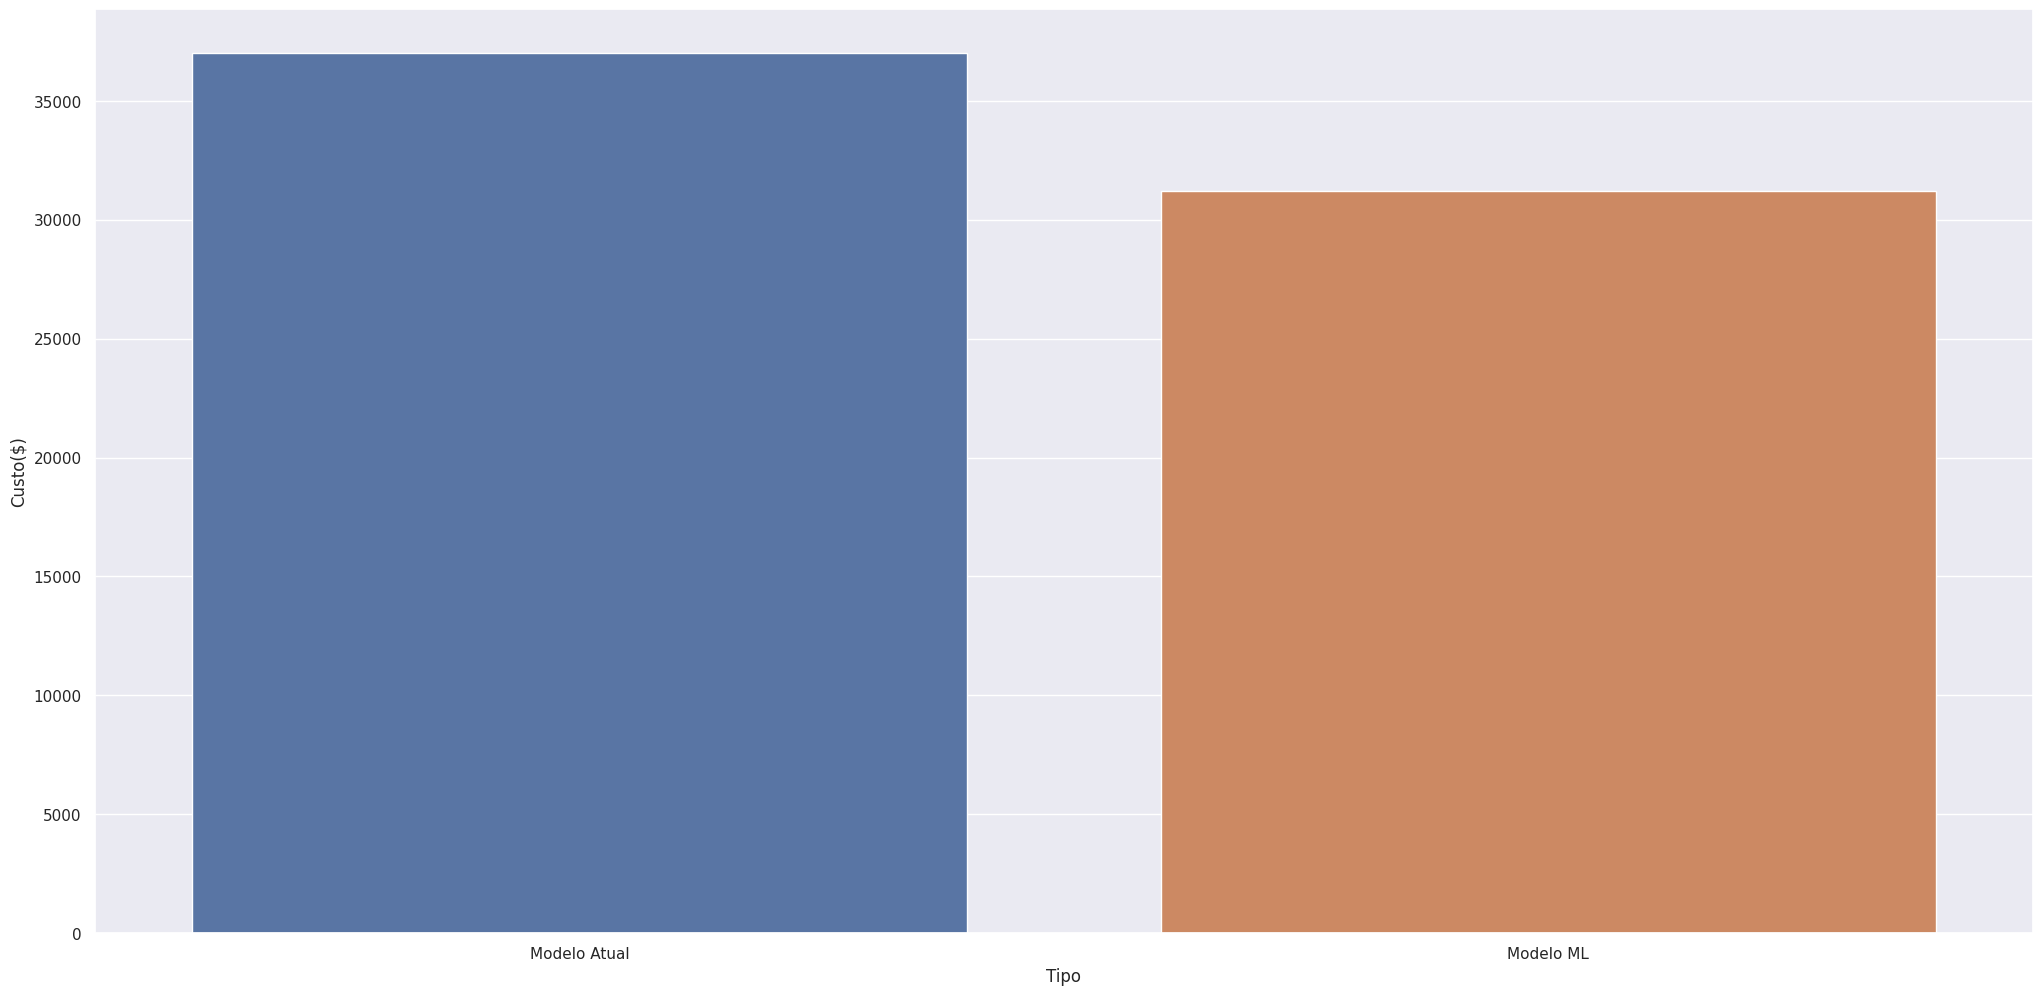

In [121]:
sns.barplot(x='Tipo',y='Custo($)',data=df_impacto);

## 10.4 Conclusões e Trabalhos Futuros

### 10.4.1 Conclusões 

* Nesse projeto, foram realizadas todas as etapas necessárias para a implementação de um projeto completo de Data Science em um ambiente de produção. Foi utilizado o método de gerenciamento de projeto chamado CRISP-DM/DS e obteve-se um desempenho satisfatório utilizando o modelo de Classificação XGBoost para realizar a identificação de problemas com o sistema de manutenção de ar de uma empresa tercerizada de transporte de caminhões com objetivo de diminuir o custo da empresa com esse tipo de manutenção. A economia gerada pelo modelo sugerido foi $5.775 doláres.

* Durante o desenvolvimento do projeto realizamos um estudo sobre as features mais importantes para o modelo(Seção 6.1.3), levando isso em consideração podemos observar que 2 principais features foram consideradas as mais importantes para o nosso modelo (ci_000,bj_000). Portanto seria interessante analisarmos o que elas realmente significam no contexto do negócio, para que assim, melhores decisões possam ser tomadas quanta ao tratamento dessas features na vida real.



### 10.4.2 Trabalhos Futuros

Como futuros trabalhos, nós podemos solicitar ao time de negócio a desanonimização das features presentes nos dados e com isso podemos realizar as seguintes tarefas de maneira mais clara:

* MindMap de Hipóteses.
* Gerar Insights de Negócio (Constatação de Hipóteses de Negócio).
* Criar Novas Features para aumento de Perfomance do Modelo.
* Realizar Análise Exploratória dos Dados de maneira mais assertiva.

Outros tipos de melhoria que podem ser aplicadas:
- Testar outros modelos de balanceamento e o impacto gerado no modelo.
- Utilizar outros tipos de rescala ou padronização dos dados.
- Implementação de uma infraestrutura de produção mais elaborada (AWS).